In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [7]:
# pip install pandas
!pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-macosx_10_15_x86_64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-macosx_10_15_x86_64.whl (2.0 MB)


In [9]:
import lightgbm as lgb

In [43]:
df = pd.read_csv('/Users/claire/Desktop/2025-2026Fall/Learn/temperature.csv')

In [24]:
df.head()
#df.columns

,Air Temperature
Measurement Timestamp,
2016-01-01 00:00:00,-2.8
2016-01-01 01:00:00,-3.4
2016-01-01 02:00:00,-4.2
2016-01-01 03:00:00,-5.1
2016-01-01 04:00:00,-5.7


In [ ]:
# missing_mask = df.isna().sum()
# missing_mask

In [44]:
df['Measurement Timestamp'] = pd.to_datetime(
    df['Measurement Timestamp'],
    format='%m/%d/%Y %I:%M:%S %p'
)


In [ ]:
#df = df.set_index('Measurement Timestamp').sort_index()

In [13]:
df.head()

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,2016-01-01 00:00:00,-2.80
1,Oak Street Weather Station,2016-01-01 00:00:00,-2.30
2,Foster Weather Station,2016-01-01 00:00:00,-3.67
3,63rd Street Weather Station,2016-01-01 01:00:00,-3.40
4,Foster Weather Station,2016-01-01 01:00:00,-4.56


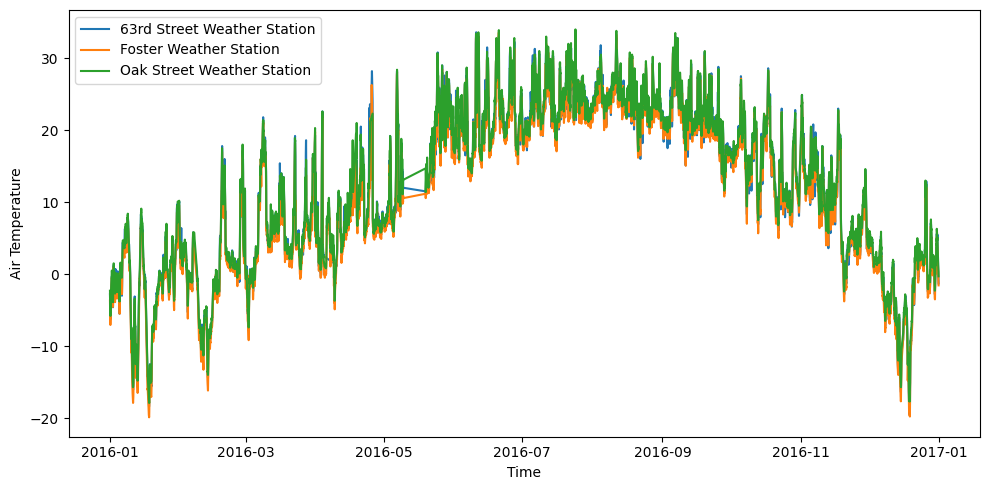

In [ ]:
df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'])
df = df.sort_values('Measurement Timestamp')

df_wide = df.pivot(
    index='Measurement Timestamp',
    columns='Station Name',
    values='Air Temperature'
)

fig, ax = plt.subplots(figsize=(10, 5))

for col in df_wide.columns:
    s = df_wide[col].dropna()
    ax.plot(s.index, s.values, label=col)

ax.set_xlabel('Time')
ax.set_ylabel('Air Temperature')
ax.legend()
plt.tight_layout()
plt.show()

#In 3 separate plots
# fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# for ax, station in zip(axes, df_wide.columns):
#     s = df_wide[station].dropna()
#     ax.plot(s.index, s.values)
#     ax.set_title(station)

# plt.tight_layout()
# plt.show()


In [22]:
#Alternative easy plot

plt.figure(figsize=(10, 5))

for station, g in df.groupby('Station Name'):
    plt.plot(
        g['Measurement Timestamp'],
        g['Air Temperature'],
        label=station
    )

plt.xlabel('Time')
plt.ylabel('Air Temperature')
plt.title('Air Temperature by Weather Station')
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'Station Name'

<Figure size 1000x500 with 0 Axes>

In [45]:
df = df.set_index('Measurement Timestamp')

In [46]:

# enforce hourly frequency per station
df = (
    df
    .groupby('Station Name', group_keys=False)
    .apply(lambda g: g.asfreq('h'))
)

In [54]:
df['Station Name'] = (
    df
    .groupby('Station Name')['Station Name']
    .ffill()
    .bfill()
)

✓ df shape: (26352, 2), columns: ['Station Name', 'Air Temperature']
✓ Station Name unique values: 3


In [40]:
df.index.freq
# Hourly frequency

df['Air Temperature'].isna().sum()
# > 0 (missing timestamps exposed), sanity check


df type: <class 'pandas.DataFrame'>
columns: ['Measurement Timestamp', 'Air Temperature']
index names: [None]
shape: (3, 2)


,Measurement Timestamp,Air Temperature
1970-01-01 00:00:00.000000000,NaT,NaN
1970-01-01 00:00:00.000000002,NaT,NaN
1970-01-01 00:00:00.000000001,NaT,NaN


In [ ]:
# from pykalman import KalmanFilter

In [ ]:
# def kalman_fill(series):
#     kf = KalmanFilter(
#         transition_matrices=[1],
#         observation_matrices=[1],
#         initial_state_mean=series.dropna().iloc[0],
#         initial_state_covariance=1,
#         observation_covariance=1,
#         transition_covariance=0.01
#     )

#     state_means, _ = kf.smooth(series.values)
#     return state_means.flatten()

# df['Air Temperature_kalman'] = (
#     df
#     .groupby('Station Name')['Air Temperature']
#     .transform(kalman_fill)
# )

# # keep original values where observed
# df['Air Temperature_filled'] = df['Air Temperature']
# mask = df['Air Temperature'].isna()
# df.loc[mask, 'Air Temperature_filled'] = df.loc[mask, 'Air Temperature_kalman']


# station = '63rd Street Weather Station'
# g = df[df['Station Name'] == station]

# plt.figure(figsize=(10, 4))
# plt.plot(g.index, g['Air Temperature'],  '.', alpha=0.4, label='Observed')
# plt.plot(g.index, g['Air Temperature_filled'], label='Filled (Kalman only on NA)')
# plt.legend()
# plt.title(station)
# plt.show()

In [ ]:
# temp = df['Air Temperature']
# model = sm.tsa.UnobservedComponents(temp, level = 'local level')
# res = model.fit()
# df['Air Temperature_filled'] = res.level.smoothed 
# df.loc[df['Air Temperature'].notna(), 'Air Temperature_filled'] = df.loc[df['Air Temperature'].notna(), 'Air Temperature']


def kalman_fill_sm(series):
    model = sm.tsa.UnobservedComponents(
        series,
        level='local level'
    )
    res = model.fit(disp=False)
    # return res.smoothed_state[0]
    return res.level.smoothed 

df['Air Temperature_filled'] = (
    df
    .groupby('Station Name')['Air Temperature']
    .transform(kalman_fill_sm)
)

df.loc[df['Air Temperature'].notna(), 'Air Temperature_filled'] = df.loc[df['Air Temperature'].notna(), 'Air Temperature']

/Users/claire/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/claire/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/Users/claire/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/claire/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/Users/claire/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarn

In [ ]:
df.index.freq
# Hourly frequency
df['Air Temperature_filled'].isna().sum()

mask = df['Air Temperature'].isna()
df.loc[mask]

,Station Name,Air Temperature,Air Temperature_filled
Measurement Timestamp,,,
2016-01-03 00:00:00,63rd Street Weather Station,NaN,-1.500000
2016-01-05 07:00:00,63rd Street Weather Station,NaN,-5.350000
2016-01-06 22:00:00,63rd Street Weather Station,NaN,3.476923
2016-01-06 23:00:00,63rd Street Weather Station,NaN,3.553846
2016-01-07 00:00:00,63rd Street Weather Station,NaN,3.630769
...,...,...,...
2016-12-20 00:00:00,Oak Street Weather Station,NaN,-7.150000
2016-12-23 12:00:00,Oak Street Weather Station,NaN,4.100000
2016-12-25 00:00:00,Oak Street Weather Station,NaN,2.366667


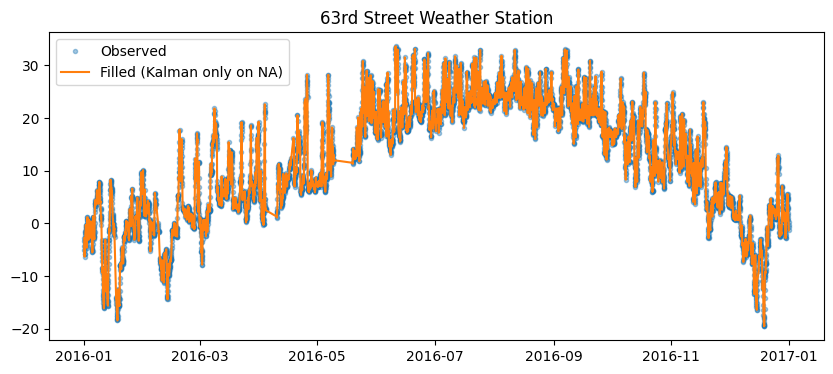

In [ ]:
station = '63rd Street Weather Station'
g = df[df['Station Name'] == station]

plt.figure(figsize=(10, 4))
plt.plot(g.index, g['Air Temperature'], '.', alpha=0.4,  label='Observed')
plt.plot(g.index, g['Air Temperature_filled'], label='Filled (Kalman only on NA)')
plt.legend()
plt.title(station)
plt.show()

## Data cleaning is done above, Next is Data Analysis

In [ ]:
df.groupby('Station Name')['Air Temperature_filled'].describe()

,count,mean,std,min,25%,50%,75%,max
Station Name,,,,,,,,
63rd Street Weather Station,8784.0,11.928165,10.783294,-19.50,3.200000,11.960970,21.50,33.60
Foster Weather Station,8784.0,11.214656,10.853278,-19.89,2.770385,11.086350,20.78,33.56
Oak Street Weather Station,8784.0,12.492333,10.793384,-17.90,3.800000,13.488708,21.90,34.00


In [ ]:
# df['temp_roll_24h'] = (
#     df.groupby('Station Name')['Air Temperature_filled']
#       .transform(lambda s: s.rolling(24).mean())
# )

# Check Outlier - HOW TO DEAL WITH IT IF EXIST???
df['zscore'] = (
    df.groupby('Station Name')['Air Temperature_filled']
      .transform(lambda s: (s - s.mean()) / s.std())
)

df[df['zscore'].abs() > 4] 


,Station Name,Air Temperature,Air Temperature_filled,zscore
Measurement Timestamp,,,,


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

station = '63rd Street Weather Station'
s = df[df['Station Name'] == station]['Air Temperature_filled']


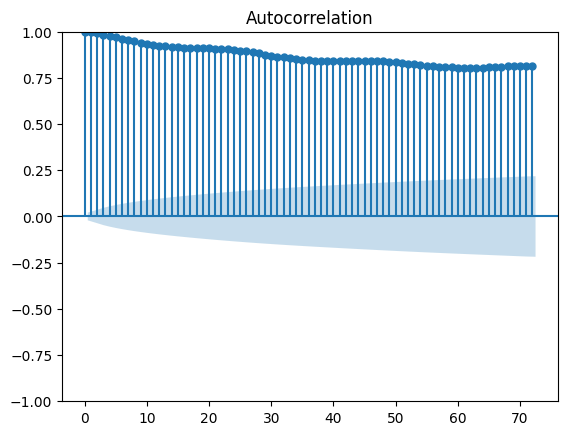

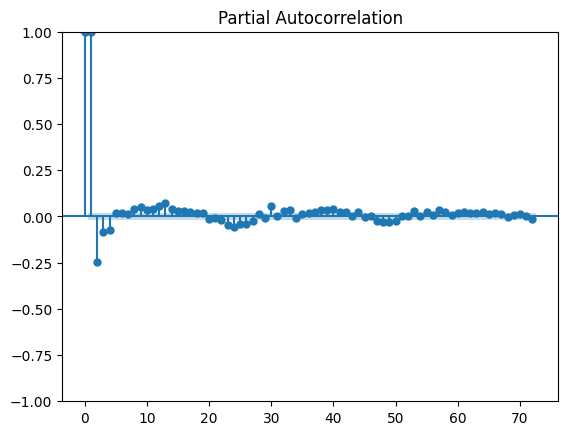

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plot_acf(s, lags=72)
plt.show()

plot_pacf(s, lags=72, method='ywm')
plt.show()


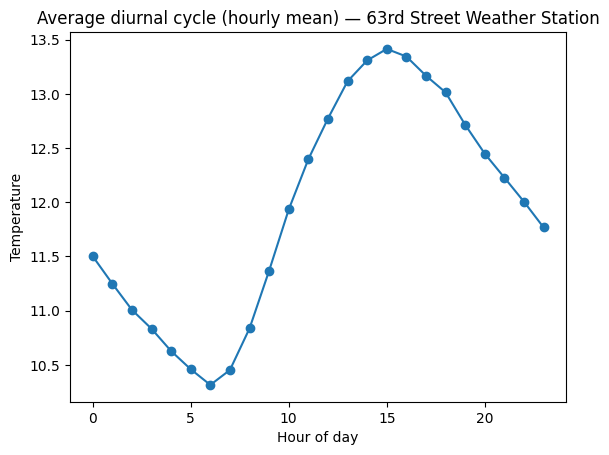

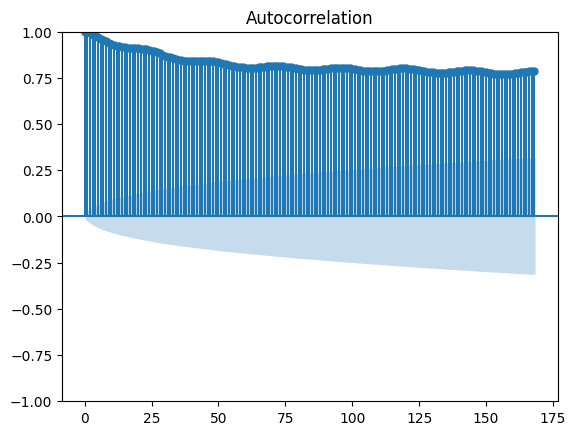

In [ ]:
# detect daily / weekly seasonlity
avg_by_hour = s.groupby(s.index.hour).mean()

avg_by_hour.plot(marker="o")
plt.xlabel("Hour of day")
plt.ylabel("Temperature")
plt.title(f"Average diurnal cycle (hourly mean) — {station}")
plt.show()

plot_acf(s.dropna(), lags=168)  # 7 days of hourly lags
plt.show()

In [ ]:
#### OPTIONAL!! FOR DAILY SEASONLITY DETECTION

from scipy.signal import periodogram

x = s.dropna().values
x = x - np.mean(x)

freq, Pxx = periodogram(x)  # assumes equal spacing (hourly)
period_hours = 1 / freq[1:]  # skip freq=0

# Find strongest periods up to, say, 200 hours
mask = period_hours < 200
best_period = period_hours[mask][np.argmax(Pxx[1:][mask])]

print("Strongest period (hours):", best_period)


Strongest period (hours): 24.0


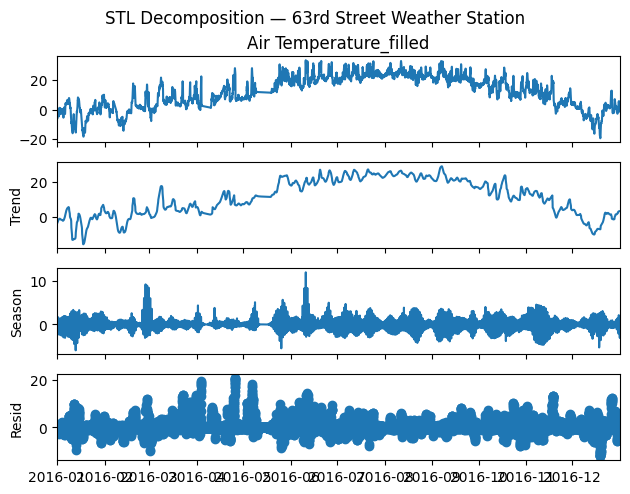

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(s, period=24, robust=True)
res = stl.fit()

res.plot()
plt.suptitle(f"STL Decomposition — {station}", y=1.02)
plt.show()

trend = res.trend
seasonal = res.seasonal
resid = res.resid


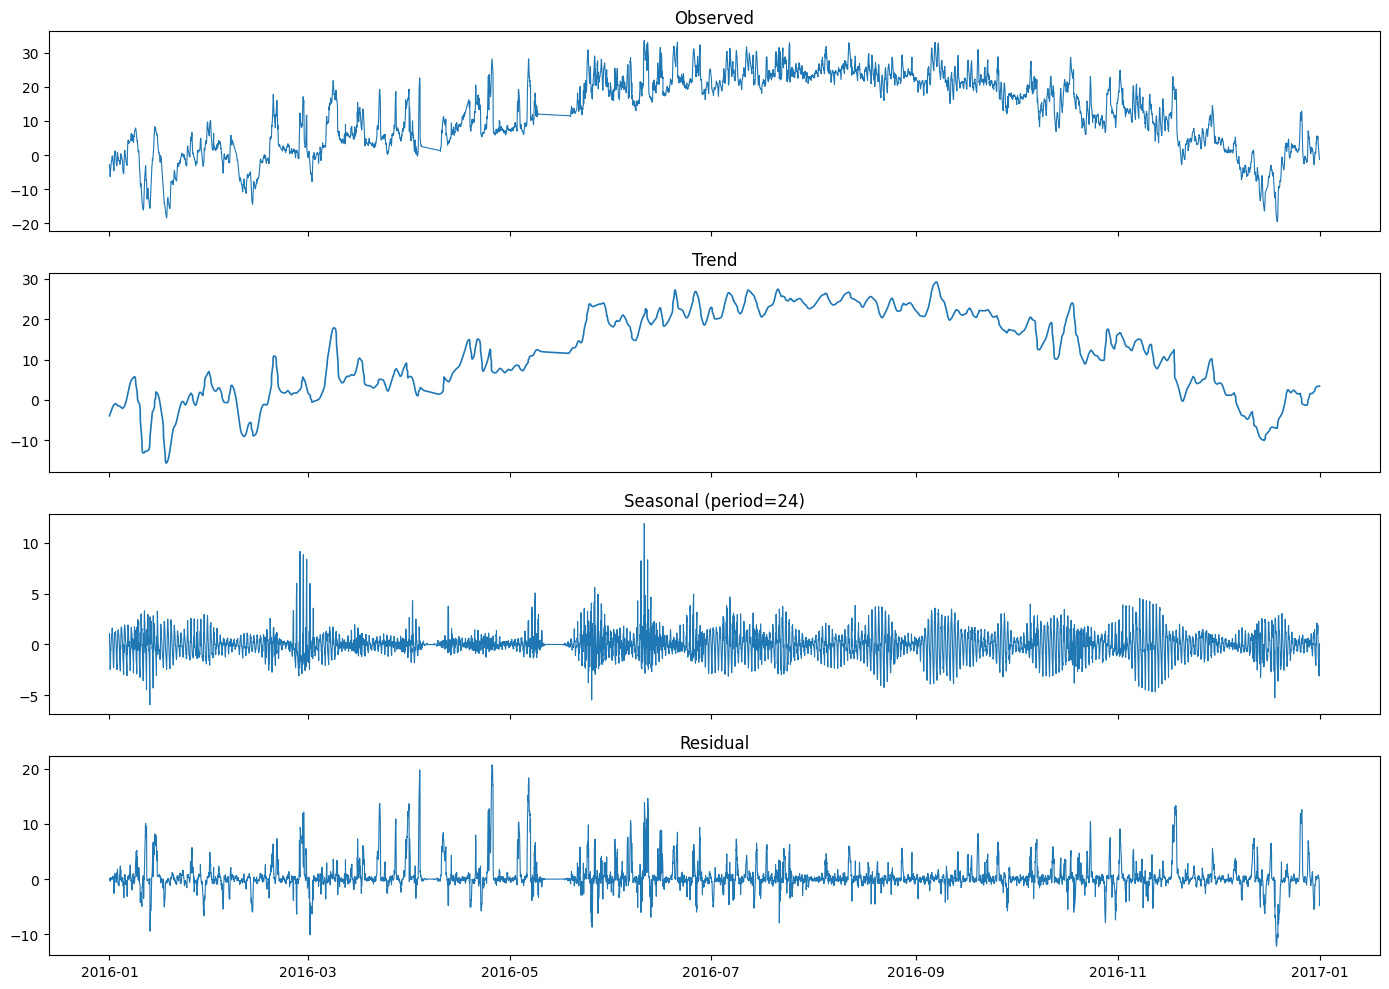

In [ ]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(s.index, s, linewidth=0.8)
axes[0].set_title("Observed")

axes[1].plot(trend.index, trend, linewidth=1.2)
axes[1].set_title("Trend")

axes[2].plot(seasonal.index, seasonal, linewidth=0.8)
axes[2].set_title("Seasonal (period=24)")

axes[3].plot(resid.index, resid, linewidth=0.8)
axes[3].set_title("Residual")

axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


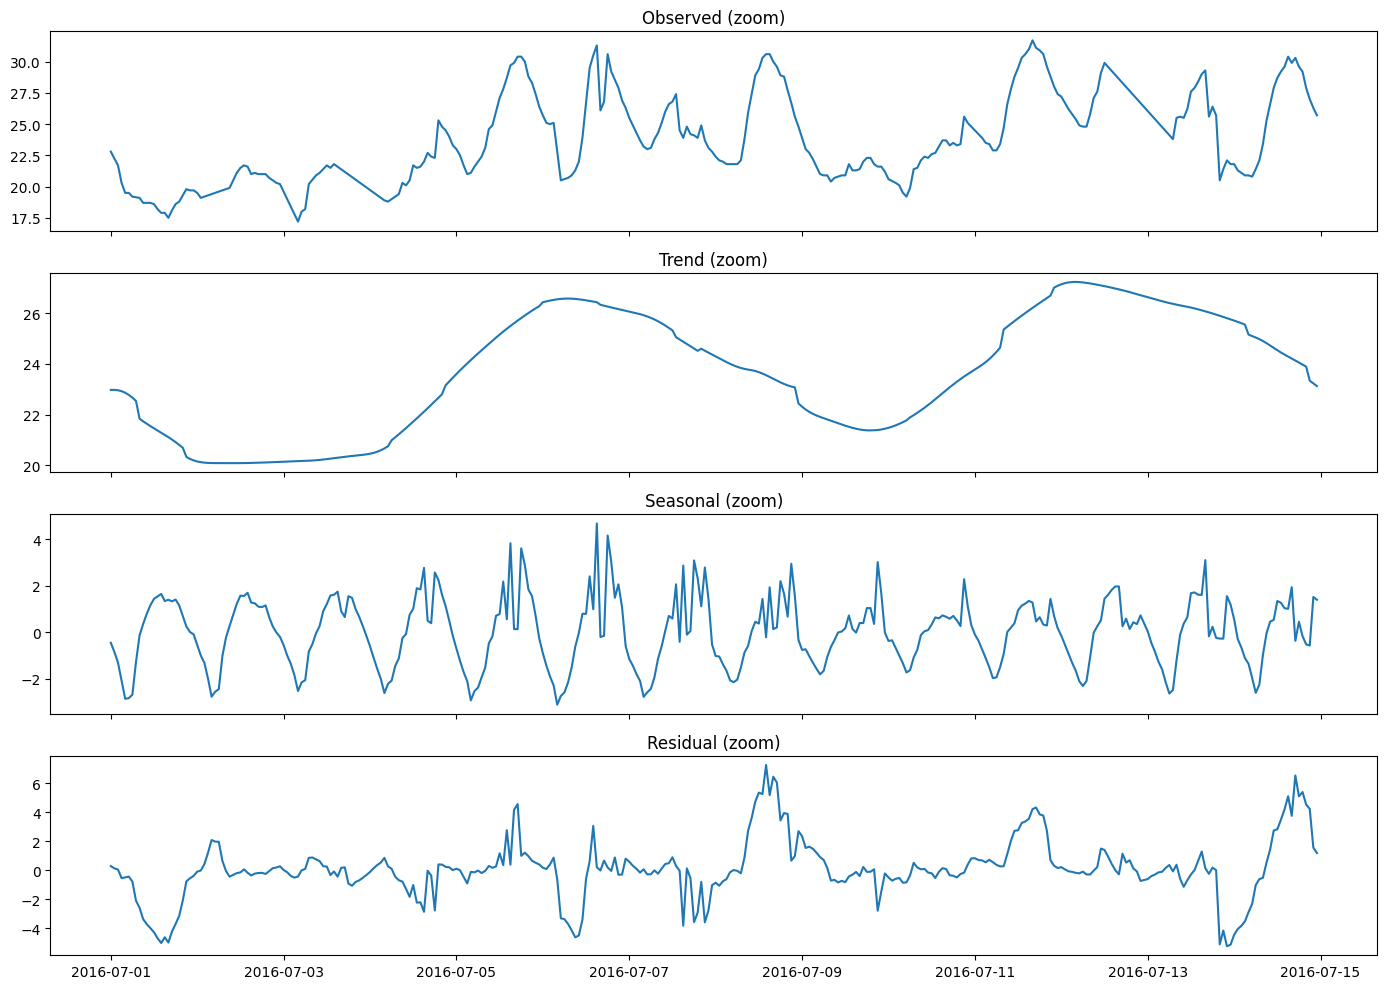

In [ ]:
# Zoom in 2 weeks
start, end = "2016-07-01", "2016-07-14"
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(s.loc[start:end])
axes[0].set_title("Observed (zoom)")

axes[1].plot(trend.loc[start:end])
axes[1].set_title("Trend (zoom)")

axes[2].plot(seasonal.loc[start:end])
axes[2].set_title("Seasonal (zoom)")

axes[3].plot(resid.loc[start:end])
axes[3].set_title("Residual (zoom)")

plt.tight_layout()
plt.show()


Comments:
2) What conclusions can you draw from your STL plot?

From your screenshot:

A. Trend is dominating the year

Your trend component rises from winter → summer and falls into winter.
That’s the annual seasonality / seasonal climate pattern being captured as “trend”.

Conclusion:
Your series has a very strong low-frequency component (yearly cycle) — so the raw series is non-stationary.

B. The “Seasonal” component is the 24-hour cycle, but it looks noisy

The seasonal band is not a clean sinusoid; it varies and has spikes. That usually implies one (or more) of:

the daily cycle amplitude changes through the year (stronger in summer, weaker in winter)

there are outliers / weird sensor episodes

remaining missingness / imputation artifacts

weather shocks that the trend can’t absorb

Conclusion:
Daily seasonality exists, but its shape/amplitude may vary across seasons.

C. Residuals are large and heavy-tailed

Your residual panel has big swings and “bursty” variance (some months look noisier).

Conclusion:
There are short-term shocks not explained by trend + daily cycle (fronts, storms), and/or sensor noise/outliers.

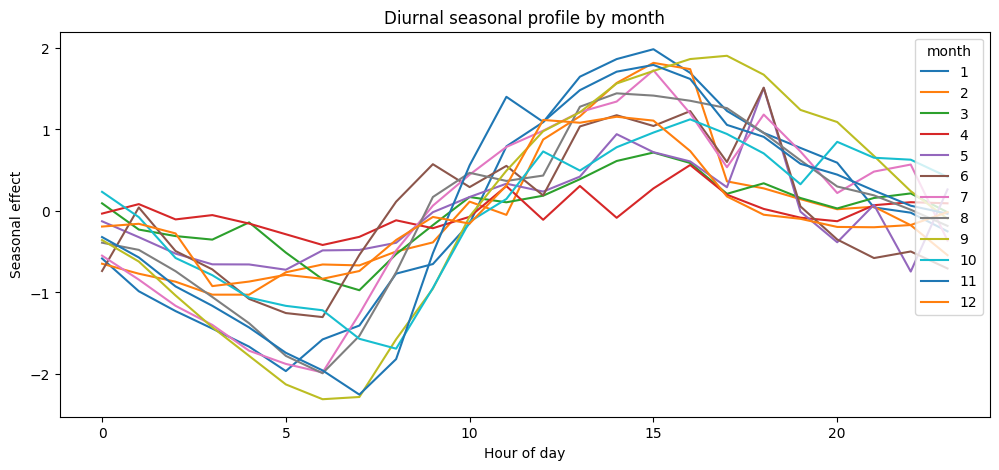

In [ ]:
tmp = seasonal.to_frame("seasonal")
tmp["month"] = tmp.index.month
tmp["hour"] = tmp.index.hour

profile = tmp.groupby(["month", "hour"])["seasonal"].mean().unstack(0)  # hours x months
profile.plot(figsize=(12,5))
plt.title("Diurnal seasonal profile by month")
plt.xlabel("Hour of day")
plt.ylabel("Seasonal effect")
plt.show()


Next steps can do: remove seasonly (quarterly) trend additionally [Use hour-of-day × month seasonal adjustment

Instead of one daily profile, estimate a separate daily profile for each month (or season).

Build a seasonal table and remove it. Improvement: use “season” buckets (DJF/MAM/JJA/SON) instead of month to reduce boundary jumps.]


#### ULTIMATE GOAL OF THIS STEP: clean up data further by removing trend/ detect seasonality; next can plot ACF/PACF to determine MA[p] for p and apply SARIMA model

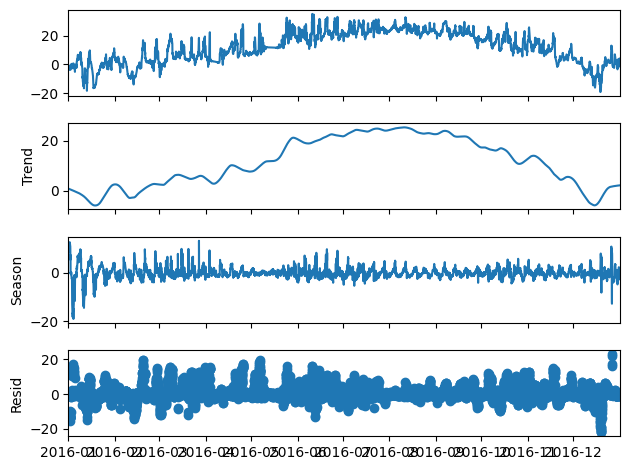

In [ ]:
# res24 = STL(s, period=24, robust=True).fit()
# detrended = s - res24.seasonal

# res168 = STL(detrended, period=168, robust=True).fit()
# res168.plot()
# plt.show()


### Regression MODEL

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
H = 24
ycol = "Air Temperature_filled"

df["y_future"] = df.groupby("Station Name")[ycol].shift(-H)
# Now each row at time t has target y_future = y(t+72).

In [ ]:
idx = df.index

# ===== Feature engineering (same as before, with station-safe rolling) =====
df["year"]  = idx.year
df["month"] = idx.month
df["day"]   = idx.day
df["hour"]  = idx.hour
df["dayofweek"] = idx.dayofweek
df["is_pm"] = (df["hour"] >= 12).astype(int)

w = 2 * np.pi * df["hour"].values / 24.0
df["sin_hour"] = np.sin(w)
df["cos_hour"] = np.cos(w)

w_week = 2 * np.pi * df["dayofweek"].values / 7.0
df["sin_dow"] = np.sin(w_week)
df["cos_dow"] = np.cos(w_week)

df["station"] = df["Station Name"].astype("category")


df["lag24"]  = df.groupby("Station Name")[ycol].shift(24)
df["lag48"]  = df.groupby("Station Name")[ycol].shift(48)
df["lag72"]  = df.groupby("Station Name")[ycol].shift(72)
df["lag168"] = df.groupby("Station Name")[ycol].shift(168)

df["trend_24h"]  = df["lag24"] - df["lag48"]
df["trend_48h"]  = df["lag24"] - df["lag72"]
df["trend_week"] = df["lag24"] - df["lag168"]

df["roll24_mean"] = (
    df.groupby("Station Name")[ycol]
      .apply(lambda s: s.shift(H).rolling(24).mean())
      .reset_index(level=0, drop=True)
)
df["roll24_std"] = (
    df.groupby("Station Name")[ycol]
      .apply(lambda s: s.shift(H).rolling(24).std())
      .reset_index(level=0, drop=True)
)
df["roll72_mean"] = (
    df.groupby("Station Name")[ycol]
      .apply(lambda s: s.shift(H).rolling(72).mean())
      .reset_index(level=0, drop=True)
)
df["roll168_mean"] = (
    df.groupby("Station Name")[ycol]
      .apply(lambda s: s.shift(H).rolling(168).mean())
      .reset_index(level=0, drop=True)
)

# ===== Model frame =====
feature_cols = [
    "year","month","day","is_pm",
    "hour","dayofweek","sin_hour","cos_hour","sin_dow","cos_dow",
    "station",
    "lag24","lag48","lag72","lag168",
    "trend_24h","trend_48h","trend_week",
    "roll24_mean","roll24_std","roll72_mean","roll168_mean",
]

df_model = df.dropna(subset=feature_cols + ["y_future"]).copy()

# ===== Split: last 24h (decision times where y_future exists) =====
test_start = df_model.index.max() - pd.Timedelta(hours=24)
train = df_model[df_model.index < test_start].copy()
test  = df_model[df_model.index >= test_start].copy()

X_train = train[feature_cols]
y_train = train["y_future"]
X_test  = test[feature_cols]
y_test  = test["y_future"]

# ===== Pipeline preprocessing =====
# You have two good options:

# Option A (recommended with Pipeline): OneHotEncode categoricals
cat_cols = ["station"]  # add more here if you decide to treat calendar fields as categorical
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", lgb.LGBMRegressor(
        n_estimators=2000,
        max_depth=8,
        learning_rate=0.03,
        num_leaves=63,
        min_child_samples=10,
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ))
])

model.fit(X_train, y_train)

pred = model.predict(X_test)

rmse = mean_squared_error(y_test, pred)
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)
print("Test window:", test_start, "to", df_model.index.max())
print({"RMSE": rmse, "MAE": mae, "R2": r2})


Test window: 2016-12-29 23:00:00 to 2016-12-30 23:00:00
{'RMSE': 9.8382124607343, 'MAE': 2.7602281623776883, 'R2': -1.3356400161343327}


/Users/claire/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


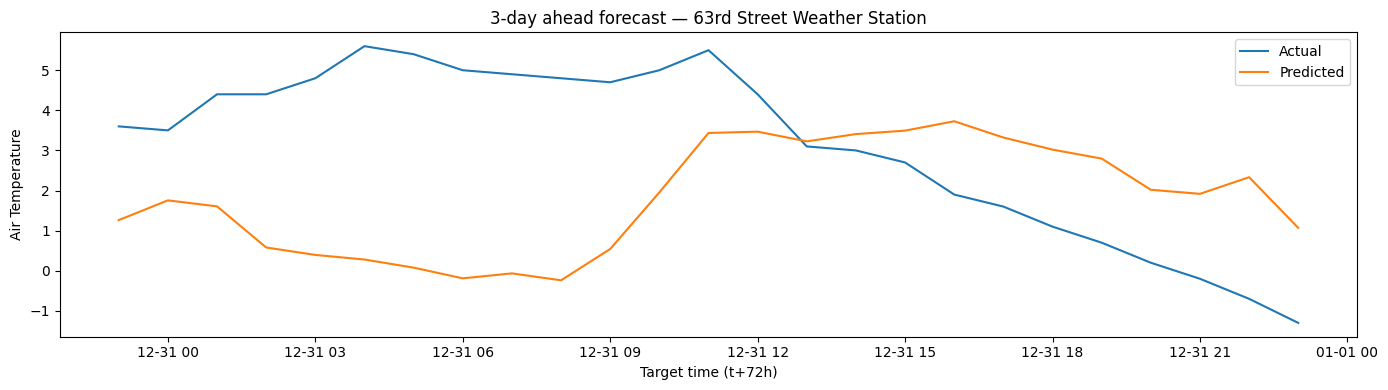

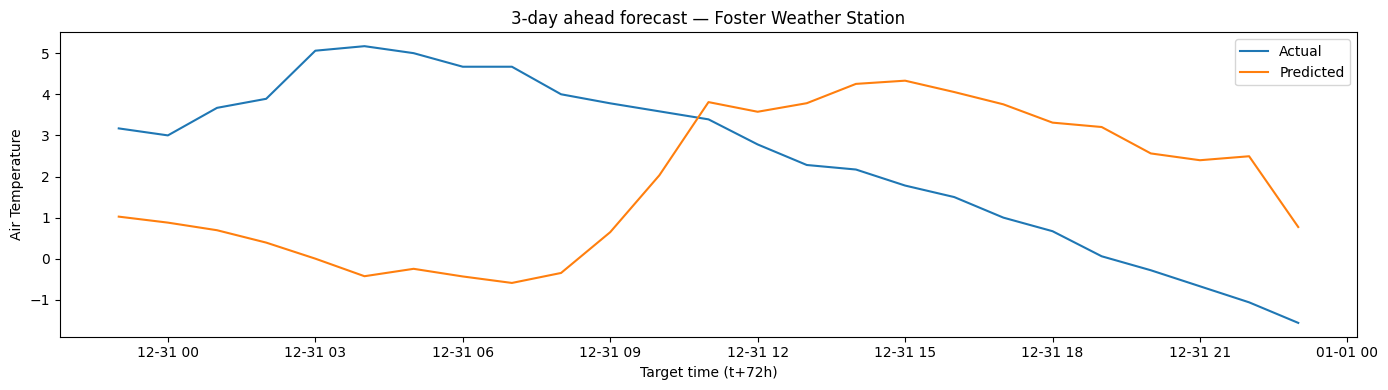

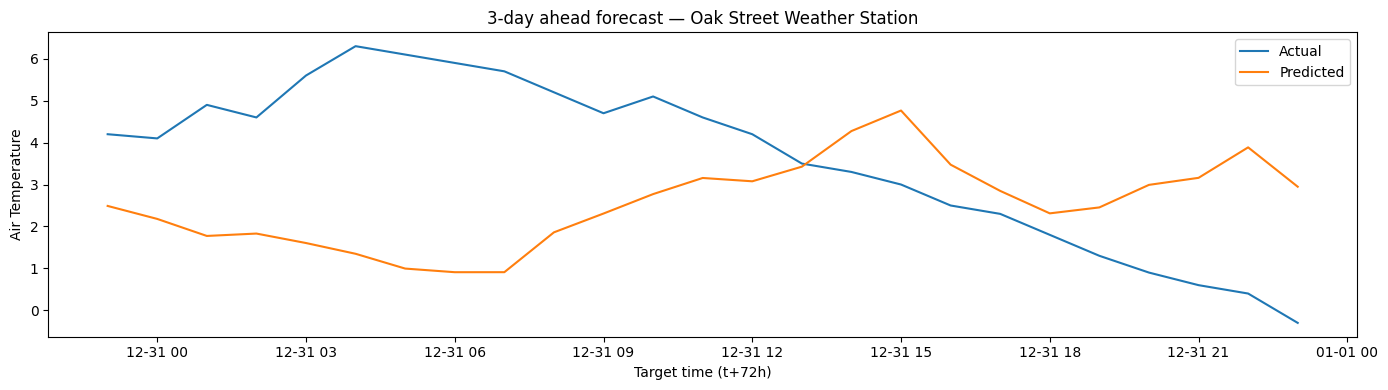

In [ ]:
res_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": pred,
    "station": X_test["station"].astype(str).values
}, index=X_test.index)

# If you want the TARGET timestamp (t+72h) on the x-axis:
H = 24
res_df["target_time"] = res_df.index + pd.Timedelta(hours=H)

# Plot per station
for st in sorted(res_df["station"].unique()):
    tmp = res_df[res_df["station"] == st].sort_values("target_time")

    plt.figure(figsize=(14, 4))
    plt.plot(tmp["target_time"], tmp["y_true"], label="Actual", linewidth=1.5)
    plt.plot(tmp["target_time"], tmp["y_pred"], label="Predicted", linewidth=1.5)
    plt.title(f"3-day ahead forecast — {st}")
    plt.xlabel("Target time (t+72h)")
    plt.ylabel("Air Temperature")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# # test rows are those whose target timestamp lies in the last 3 days for each station. 
# # We’ll implement this per station (robust if stations have different end dates):

# from pandas import Timedelta

# target_time = df.index + Timedelta(hours=H)  # timestamp of y_future

# # per-station end time (based on observed timestamps)
# end_time_by_station = df.groupby("Station Name").apply(lambda g: g.index.max())

# # map each row's station end time
# df["station_end"] = df["Station Name"].map(end_time_by_station)

# # test targets are in the last 3 days of each station's timeline
# df["is_test"] = target_time > (df["station_end"] - Timedelta(days=H/24))



# feature_cols = [
#     "year","month","day","is_pm",
#     "station",
#     "sin_hour","cos_hour",
#     "lag1","lag2","lag24","roll24_mean","roll24_std"
# ]

# data = df[feature_cols + ["y_future", "is_test"]].dropna()

# train = data[~data["is_test"]]
# test  = data[data["is_test"]]

# X_train = train[feature_cols]
# y_train = train["y_future"]

# X_test  = test[feature_cols]
# y_test  = test["y_future"]

# print("Train rows:", len(train), "Test rows:", len(test))
# print("Test target time range:",
#       (test.index + Timedelta(hours=H)).min(),
#       "to",
#       (test.index + Timedelta(hours=H)).max())


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

cat_cols = ["station", "year", "month", "day", "is_pm"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

ridge = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)




,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spa

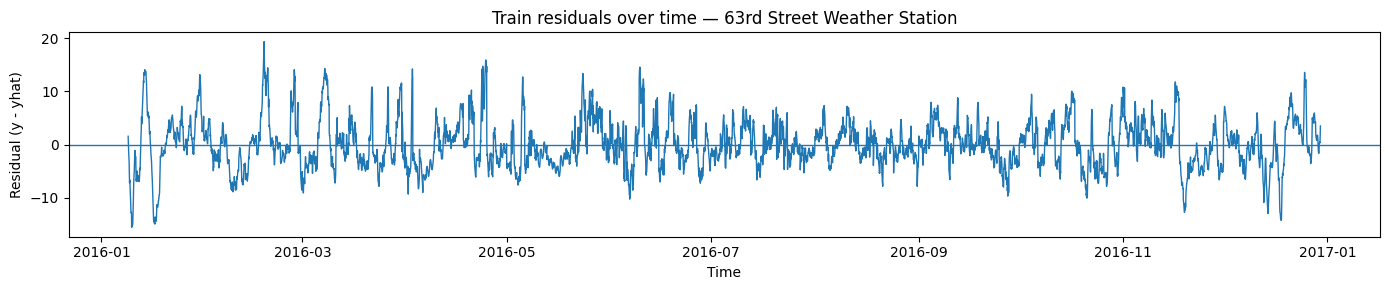

<Figure size 1200x300 with 0 Axes>

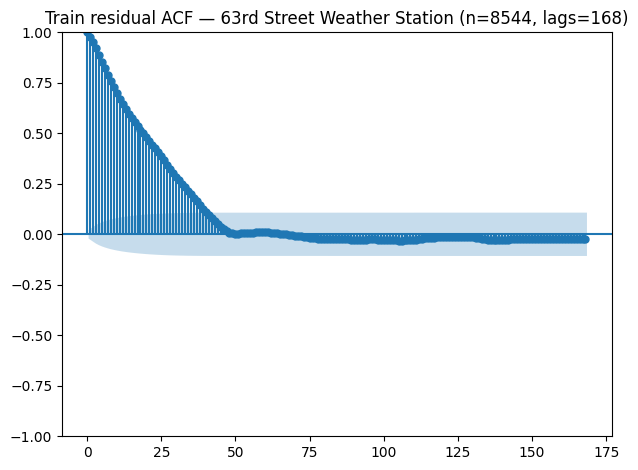

<Figure size 1200x300 with 0 Axes>

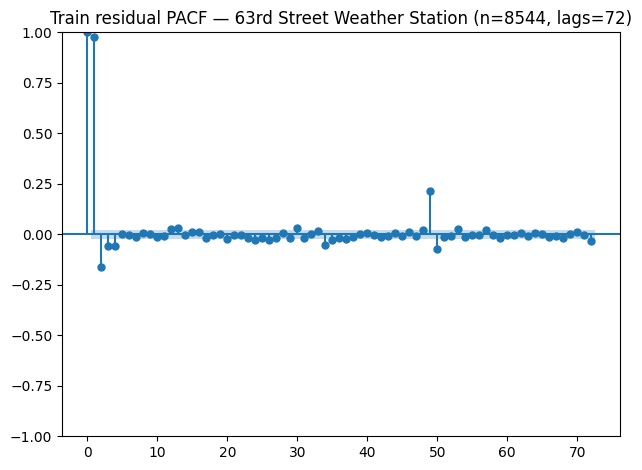

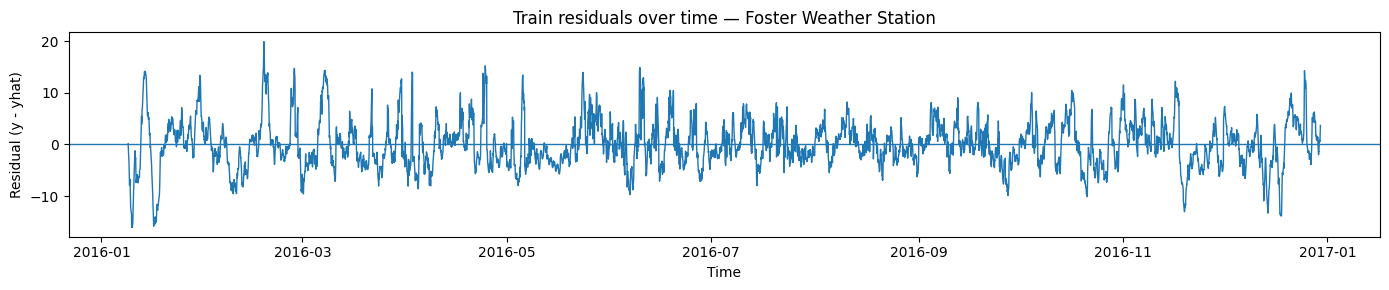

<Figure size 1200x300 with 0 Axes>

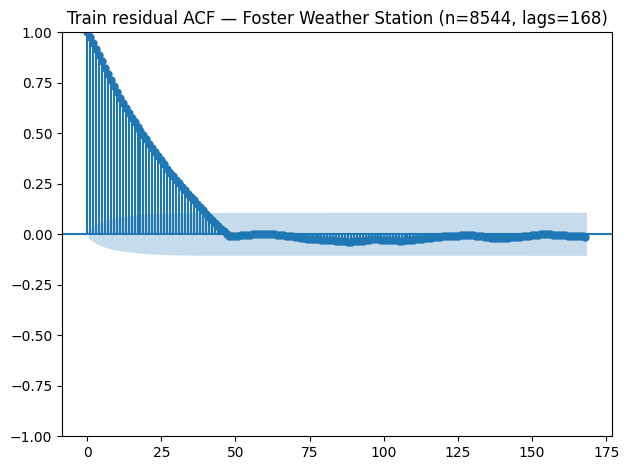

<Figure size 1200x300 with 0 Axes>

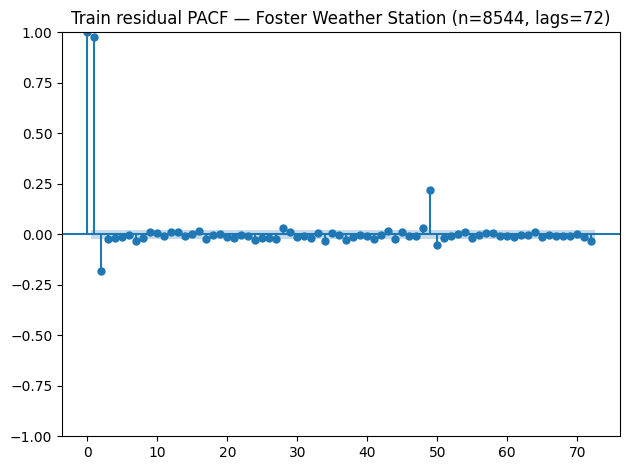

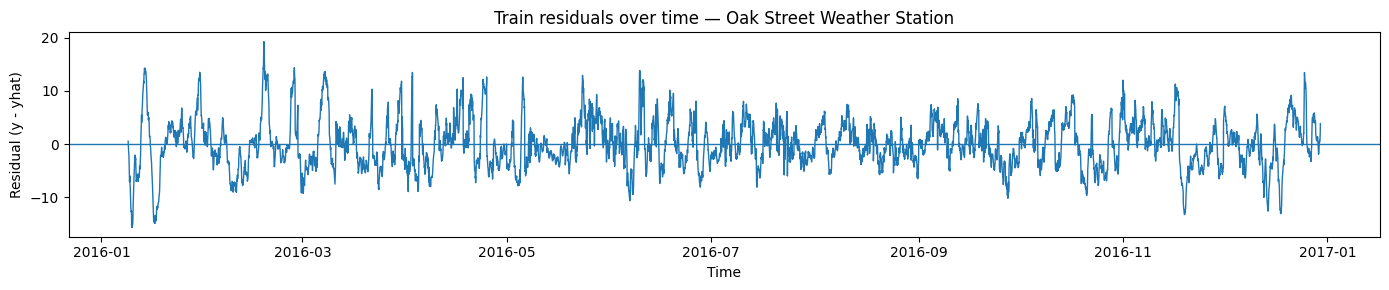

<Figure size 1200x300 with 0 Axes>

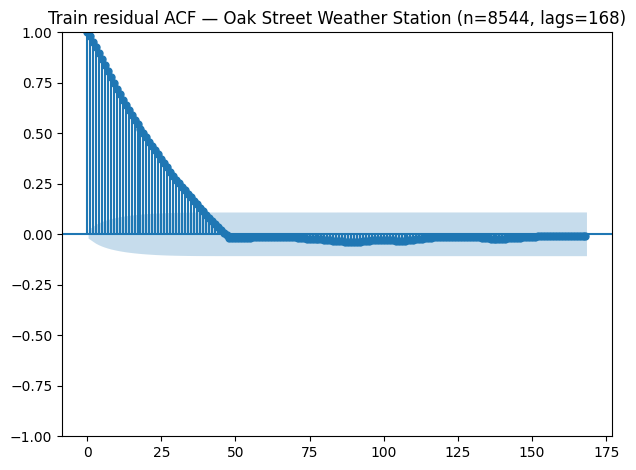

<Figure size 1200x300 with 0 Axes>

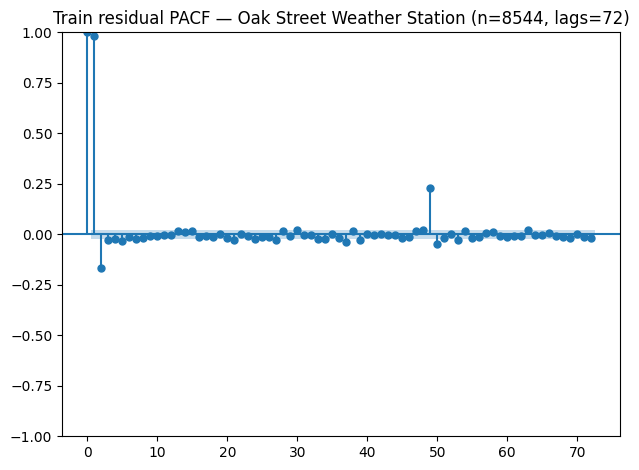

In [ ]:
pred_tr = ridge.predict(X_train)

train_res = pd.DataFrame({
    "resid": y_train.to_numpy() - pred_tr,
    "station": X_train["station"].astype(str).to_numpy()
}, index=X_train.index).sort_index()


acf_lags = 168   # 7 days
pacf_lags = 72   # 3 days (keeps PACF stable)

for st in sorted(train_res["station"].unique()):
    r = train_res.loc[train_res["station"] == st, "resid"].dropna()

    plt.figure(figsize=(14, 3))
    plt.plot(r.index, r.values, linewidth=1)
    plt.axhline(0, linewidth=1)
    plt.title(f"Train residuals over time — {st}")
    plt.xlabel("Time")
    plt.ylabel("Residual (y - yhat)")
    plt.tight_layout()
    plt.show()
    
    # safety in case one station has short history
    n = len(r)
    if n < 10:
        print(f"{st}: too few points (n={n})")
        continue
    acf_use  = min(acf_lags, n - 1)
    pacf_use = min(pacf_lags, max(1, n//2 - 1))

    plt.figure(figsize=(12, 3))
    plot_acf(r, lags=acf_use)
    plt.title(f"Train residual ACF — {st} (n={n}, lags={acf_use})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3))
    plot_pacf(r, lags=pacf_use, method="ywm")
    plt.title(f"Train residual PACF — {st} (n={n}, lags={pacf_use})")
    plt.tight_layout()
    plt.show()

In [ ]:
pred = ridge.predict(X_test)

from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print("Ridge MAE:", mae)
print("Ridge RMSE:", rmse)
print("Test  R^2:", r2_score(y_test, pred))

Ridge MAE: 4.57168721509735
Ridge RMSE: 5.363416622943655
Test  R^2: -5.829246324363125


In [ ]:
# OPTIONAL: find optimal Alpha coeffi for ridge

from sklearn.linear_model import RidgeCV

alphas = np.logspace(-3, 3, 25)

ridge_cv = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", RidgeCV(alphas=alphas))
])

ridge_cv.fit(X_train, y_train)
pred = ridge_cv.predict(X_test)

print("Best alpha:", ridge_cv.named_steps["reg"].alpha_)
print("MAE:", mean_absolute_error(y_test, pred))


Best alpha: 0.5623413251903491
MAE: 2.7250192162061158


In [ ]:
# check test datasets are split correctly
t_target = X_test.index + pd.Timedelta(hours=H)
print(t_target.min(), t_target.max())


2016-12-30 23:00:00 2016-12-31 23:00:00


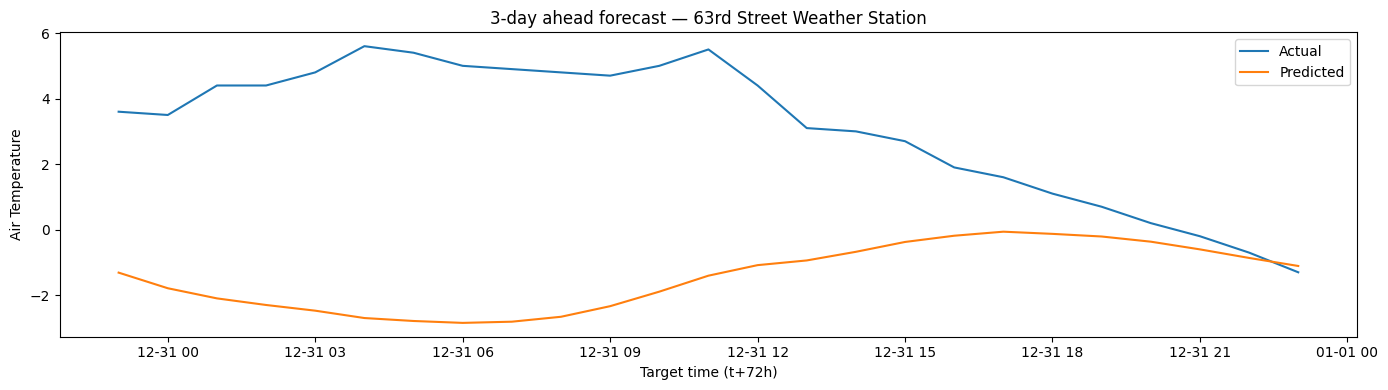

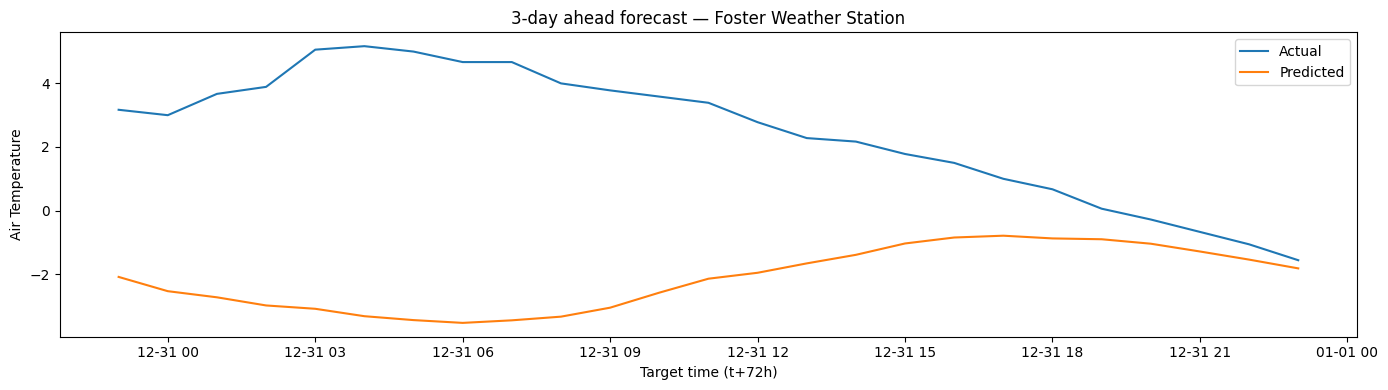

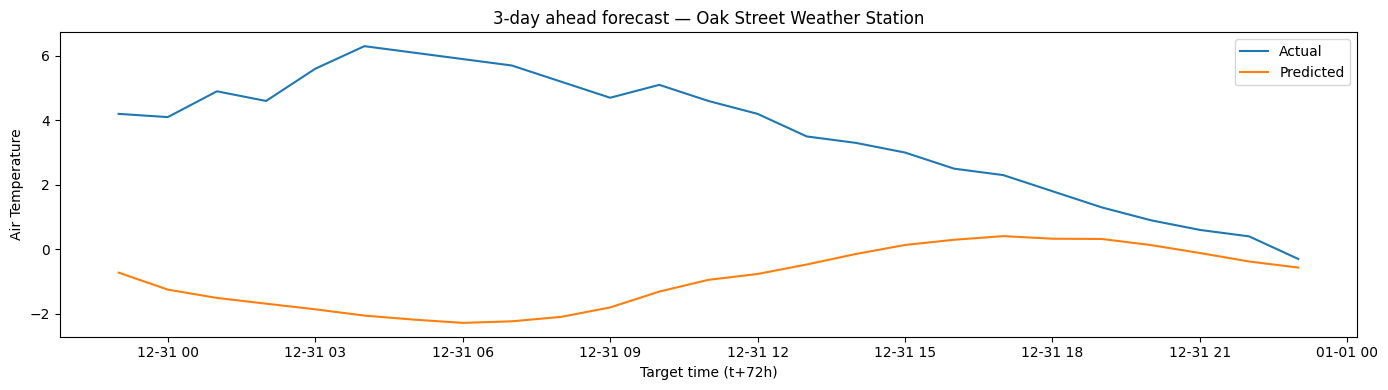

In [ ]:
res_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": pred,
    "station": X_test["station"].astype(str).values
}, index=X_test.index)

# If you want the TARGET timestamp (t+72h) on the x-axis:
H = 24
res_df["target_time"] = res_df.index + pd.Timedelta(hours=H)

# Plot per station
for st in sorted(res_df["station"].unique()):
    tmp = res_df[res_df["station"] == st].sort_values("target_time")

    plt.figure(figsize=(14, 4))
    plt.plot(tmp["target_time"], tmp["y_true"], label="Actual", linewidth=1.5)
    plt.plot(tmp["target_time"], tmp["y_pred"], label="Predicted", linewidth=1.5)
    plt.title(f"3-day ahead forecast — {st}")
    plt.xlabel("Target time (t+72h)")
    plt.ylabel("Air Temperature")
    plt.legend()
    plt.tight_layout()
    plt.show()

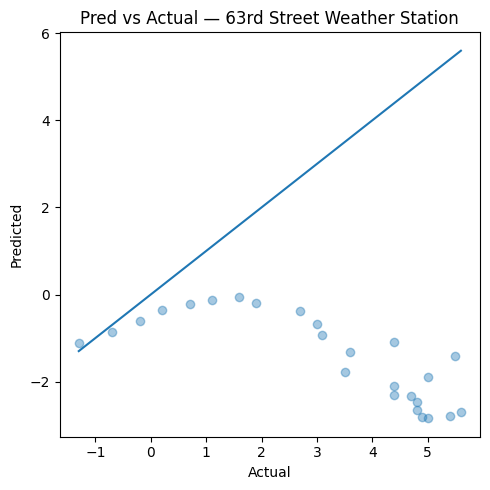

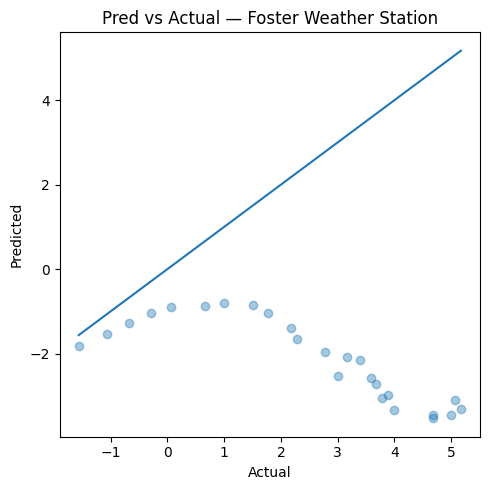

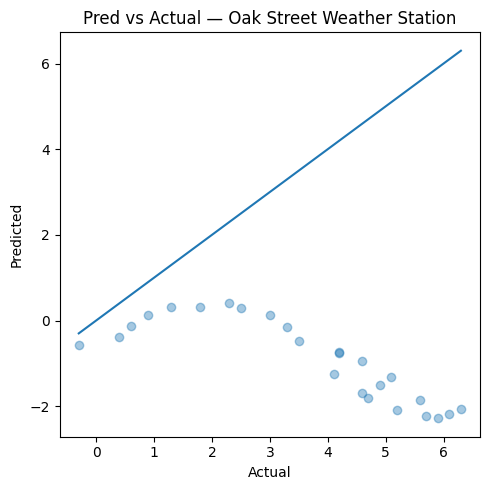

In [ ]:
for st in sorted(res_df["station"].unique()):
    tmp = res_df[res_df["station"] == st]
    plt.figure(figsize=(5,5))
    plt.scatter(tmp["y_true"], tmp["y_pred"], alpha=0.4)
    plt.plot([tmp["y_true"].min(), tmp["y_true"].max()],
             [tmp["y_true"].min(), tmp["y_true"].max()])
    plt.title(f"Pred vs Actual — {st}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()


In [ ]:
stations = sorted(res_df["station"].unique())
for st in stations:
    tmp = res_df[res_df["station"] == st].sort_values("target_time")
    print(st, tmp.shape)



63rd Street Weather Station (24, 4)
Foster Weather Station (24, 4)
Oak Street Weather Station (24, 4)


<Figure size 1200x300 with 0 Axes>

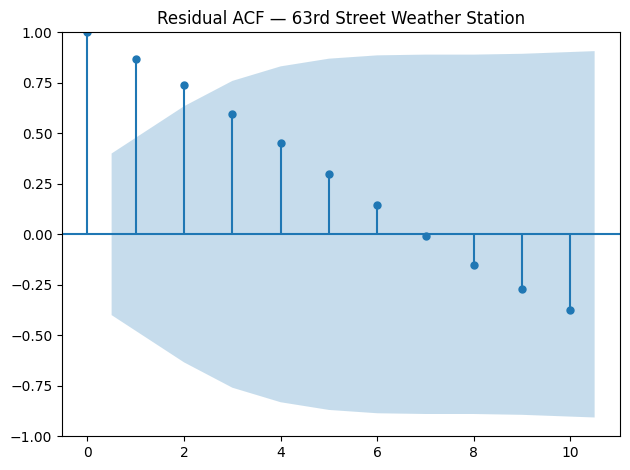

<Figure size 1200x300 with 0 Axes>

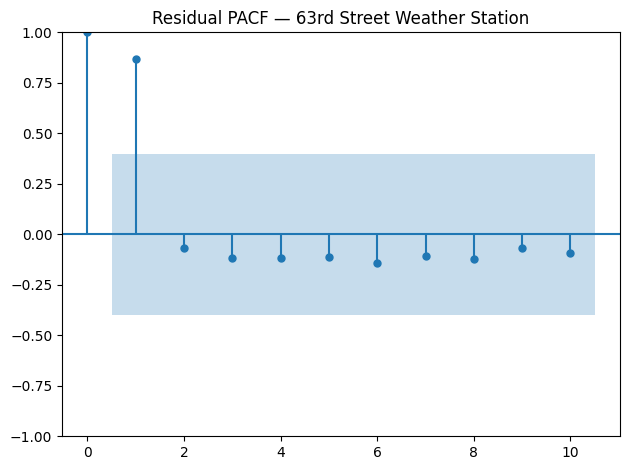

<Figure size 1200x300 with 0 Axes>

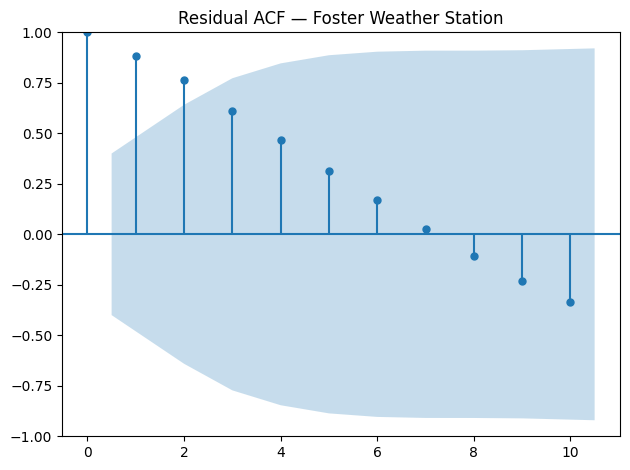

<Figure size 1200x300 with 0 Axes>

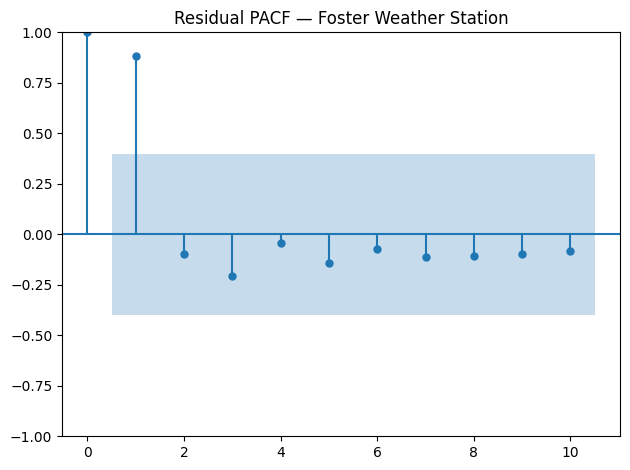

<Figure size 1200x300 with 0 Axes>

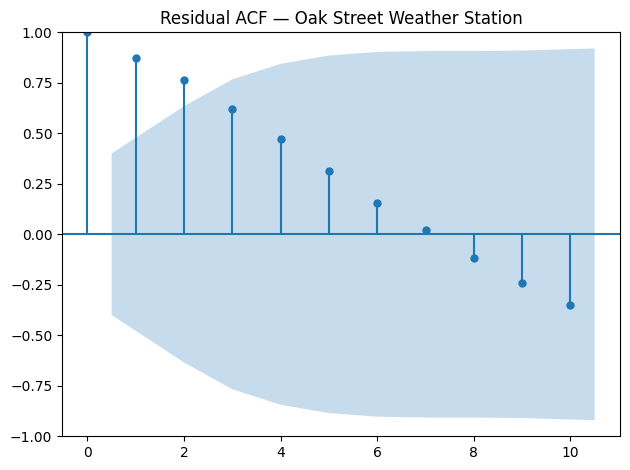

<Figure size 1200x300 with 0 Axes>

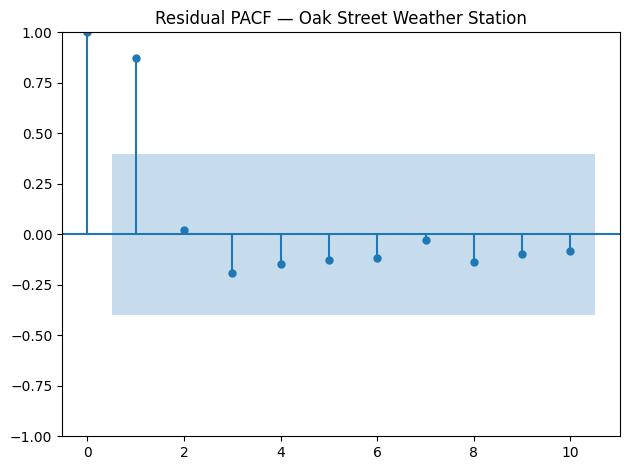

In [ ]:
res_df["resid"] = res_df["y_true"] - res_df["y_pred"]

acf_lags = 10   # 7 days
pacf_lags = 10   # 3 days (more stable)

for st in sorted(res_df["station"].unique()):
    r = res_df[res_df["station"] == st].sort_values("target_time")["resid"].dropna()

    plt.figure(figsize=(12, 3))
    plot_acf(r, lags=acf_lags)
    plt.title(f"Residual ACF — {st}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3))
    plot_pacf(r, lags=pacf_lags, method="ywm")
    plt.title(f"Residual PACF — {st}")
    plt.tight_layout()
    plt.show()

<Figure size 1200x300 with 0 Axes>

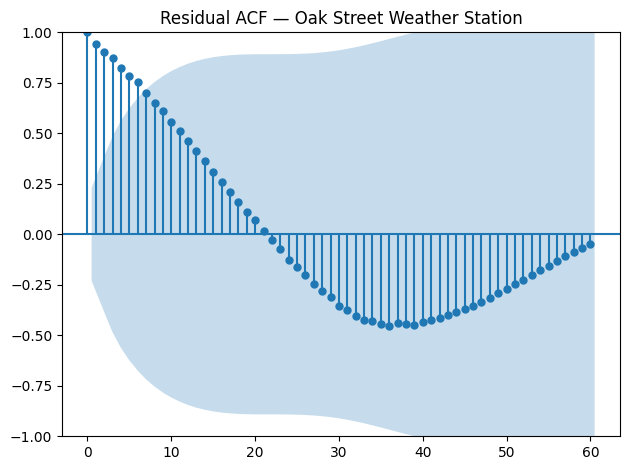

<Figure size 1200x300 with 0 Axes>

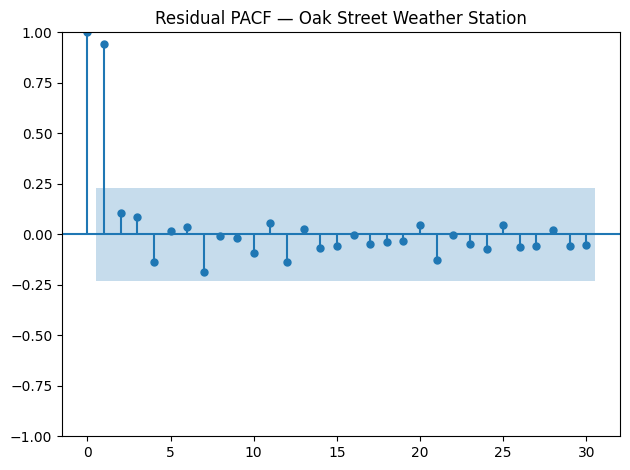

In [ ]:
r_all = res_df.sort_index()["resid"].dropna()

plt.figure(figsize=(12, 3))
plot_acf(r_all, lags=60)
plt.title(f"Residual ACF — {st}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plot_pacf(r_all, lags=30, method="ywm")
plt.title(f"Residual PACF — {st}")
plt.tight_layout()
plt.show()

### Feature Selection

In [ ]:


# model is your fitted LGBMRegressor
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance_split": model.feature_importances_,  # default in sklearn wrapper = "split"
})

# If you want "gain", use the booster:
booster = model.booster_
gain = booster.feature_importance(importance_type="gain")
split = booster.feature_importance(importance_type="split")

imp = pd.DataFrame({
    "feature": booster.feature_name(),
    "gain": gain,
    "split": split
}).sort_values("gain", ascending=False)

imp.head(20)


In [ ]:
import matplotlib.pyplot as plt

top = imp.head(20).sort_values("gain")
plt.figure()
plt.barh(top["feature"], top["gain"])
plt.title("LightGBM feature importance (gain)")
plt.show()


One more crucial detail: use a time split

Feature importance should be computed on an out-of-sample chunk, not the training set, otherwise you’ll just learn what the model used to overfit.

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Global importance
shap.summary_plot(shap_values, X_val, show=False)
import matplotlib.pyplot as plt
plt.show()

# Importance table
import numpy as np
shap_imp = pd.DataFrame({
    "feature": X_val.columns,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

shap_imp.head(20)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor

def boosting_importance_over_time(X, y, params, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    out = []

    for fold, (tr, va) in enumerate(tscv.split(X), 1):
        m = LGBMRegressor(**params)
        m.fit(X.iloc[tr], y.iloc[tr])

        b = m.booster_
        out.append(pd.DataFrame({
            "feature": b.feature_name(),
            "gain": b.feature_importance(importance_type="gain"),
            "split": b.feature_importance(importance_type="split"),
            "fold": fold
        }))

    all_imp = pd.concat(out, ignore_index=True)

    summary = (all_imp
               .groupby("feature")[["gain","split"]]
               .agg(["mean","std"])
               .sort_values(("gain","mean"), ascending=False))
    return summary, all_imp

# usage:
# params = dict(n_estimators=2000, learning_rate=0.02, num_leaves=64, subsample=0.8, colsample_bytree=0.8, random_state=42)
# summary, per_fold = boosting_importance_over_time(X, y, params, n_splits=5)
# summary.head(20)


### Another Regression Ridge


In [ ]:
idx = df.index

df["year"]  = idx.year
df["month"] = idx.month
df["day"]   = idx.day

# AM vs PM: 0 for AM (0–11), 1 for PM (12–23)
df["is_pm"] = (idx.hour >= 12).astype(int)


df["station"] = df["Station Name"].astype("category")


hour = df.index.hour.values
w = 2 * np.pi * hour / 24

df["sin_hour"] = np.sin(w)
df["cos_hour"] = np.cos(w)



ycol = "Air Temperature_filled"

# lags
df["lag1"]   = df.groupby("Station Name")[ycol].shift(1)
df["lag2"]   = df.groupby("Station Name")[ycol].shift(2)
df["lag24"]  = df.groupby("Station Name")[ycol].shift(24)
df["lag168"] = df.groupby("Station Name")[ycol].shift(168)   # optional weekly

# rolling features (shift(1) avoids leakage)
df["roll24_mean"] = (
    df.groupby("Station Name")[ycol]
      .shift(1)
      .rolling(24)
      .mean()
)

df["roll24_std"] = (
    df.groupby("Station Name")[ycol]
      .shift(1)
      .rolling(24)
      .std()
)


In [ ]:
# test rows are those whose target timestamp lies in the last 3 days for each station. 
# We’ll implement this per station (robust if stations have different end dates):

from pandas import Timedelta

target_time = df.index + Timedelta(hours=H)  # timestamp of y_future

# per-station end time (based on observed timestamps)
end_time_by_station = df.groupby("Station Name").apply(lambda g: g.index.max())

# map each row's station end time
df["station_end"] = df["Station Name"].map(end_time_by_station)

# test targets are in the last 3 days of each station's timeline
df["is_test"] = target_time > (df["station_end"] - Timedelta(days=H/24))


In [ ]:

feature_cols = [
    "year","month","day","is_pm",
    "station",
    "sin_hour","cos_hour",
    "lag1","lag2","lag24","roll24_mean","roll24_std"
]

data = df[feature_cols + ["y_future", "is_test"]].dropna()

train = data[~data["is_test"]]
test  = data[data["is_test"]]

X_train = train[feature_cols]
y_train = train["y_future"]

X_test  = test[feature_cols]
y_test  = test["y_future"]

print("Train rows:", len(train), "Test rows:", len(test))
print("Test target time range:",
      (test.index + Timedelta(hours=H)).min(),
      "to",
      (test.index + Timedelta(hours=H)).max())


In [ ]:
pred = ridge.predict(X_test)

from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print("Ridge MAE:", mae)
print("Ridge RMSE:", rmse)
print("Test  R^2:", r2_score(y_test, pred))

### Time Series MODEL

In [ ]:

last_day = s.index.max().normalize()     # midnight of last day
next_day = last_day + pd.Timedelta(days=1)

# Split
s_train = s[s.index < last_day]
s_test  = s[(s.index >= last_day) & (s.index < next_day)]

print("Train range:", s_train.index.min(), "->", s_train.index.max(), "n=", len(s_train))
print("Test range: ", s_test.index.min(),  "->", s_test.index.max(),  "n=", len(s_test))


Train range: 2016-01-01 00:00:00 -> 2016-12-30 23:00:00 n= 8760
Test range:  2016-12-31 00:00:00 -> 2016-12-31 23:00:00 n= 24


In [ ]:
assert s_train.index.max() < s_test.index.min()
assert s_test.index.normalize().nunique() == 1  # exactly one calendar day

In [ ]:
m = 24
s_seasdiff = s_train.diff(m).dropna()


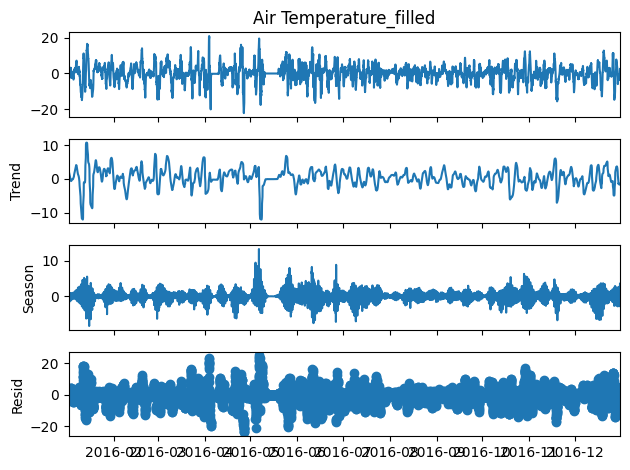

In [ ]:
stl_seasdiff = STL(s_seasdiff, period=m, robust=True)
res_seasdiff = stl_seasdiff.fit()

res_seasdiff.plot()
plt.show()

trend_diff = res_seasdiff.trend
seasonal_diff = res_seasdiff.seasonal
remainder_diff = res_seasdiff.resid
# no obbious trend -> d = 0 (o/w d = 1), D = 1

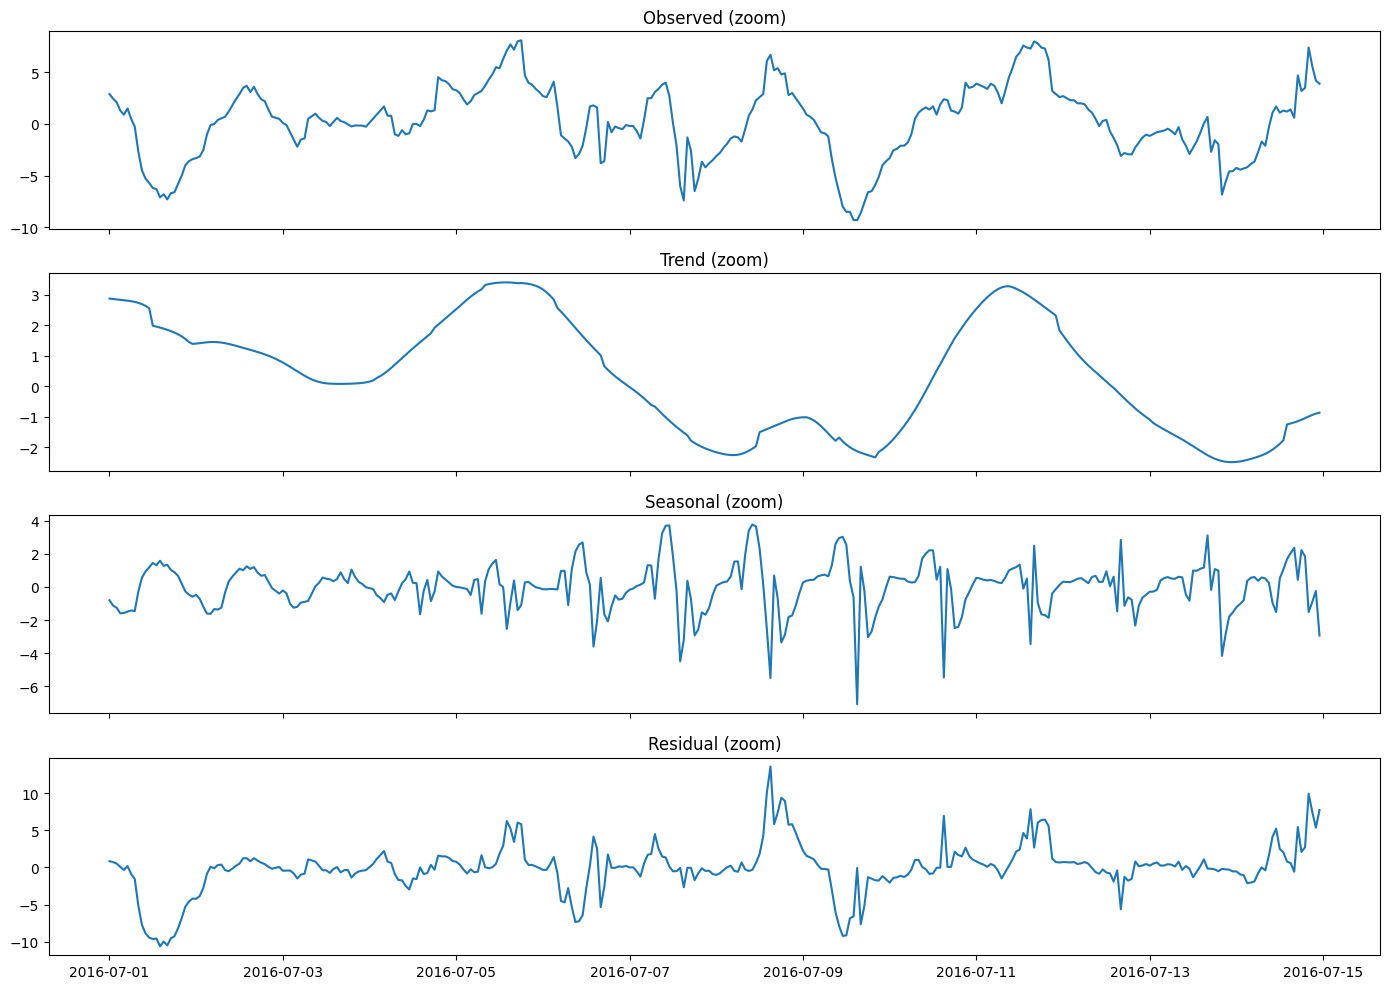

In [ ]:
start, end = "2016-07-01", "2016-07-14"
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(s_seasdiff.loc[start:end])
axes[0].set_title("Observed (zoom)")

axes[1].plot(trend_diff.loc[start:end])
axes[1].set_title("Trend (zoom)")

axes[2].plot(seasonal_diff.loc[start:end])
axes[2].set_title("Seasonal (zoom)")

axes[3].plot(remainder_diff.loc[start:end])
axes[3].set_title("Residual (zoom)")

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(x, regression="c"):
    stat, pval, usedlag, nobs, crit, icbest = adfuller(x, regression=regression, autolag="AIC")
    return {"ADF stat": stat, "p": pval, "lags": usedlag, "nobs": nobs, "crit": crit, "icbest": icbest}

def kpss_test(x, regression="c"):
    stat, pval, lags, crit = kpss(x, regression=regression, nlags="auto")
    return {"KPSS stat": stat, "p": pval, "lags": lags, "crit": crit}

# Example: test seasonal-differenced series
print("ADF(z):", adf_test(s_seasdiff, regression="c"))
print("KPSS(z):", kpss_test(s_seasdiff, regression="c"))

ADF(z): {'ADF stat': np.float64(-16.13878270453958), 'p': np.float64(4.700164179223091e-29), 'lags': 37, 'nobs': 8698, 'crit': {'1%': np.float64(-3.4311020385052733), '5%': np.float64(-2.8618723508056814), '10%': np.float64(-2.566946905374546)}, 'icbest': np.float64(24864.983605249472)}
KPSS(z): {'KPSS stat': np.float64(0.06134318287245064), 'p': np.float64(0.1), 'lags': 53, 'crit': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}}


/var/folders/gf/6s0vyl8d39jf2s8jz7v2yd6c0000gn/T/ipykernel_1141/2337170119.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(x, regression=regression, nlags="auto")


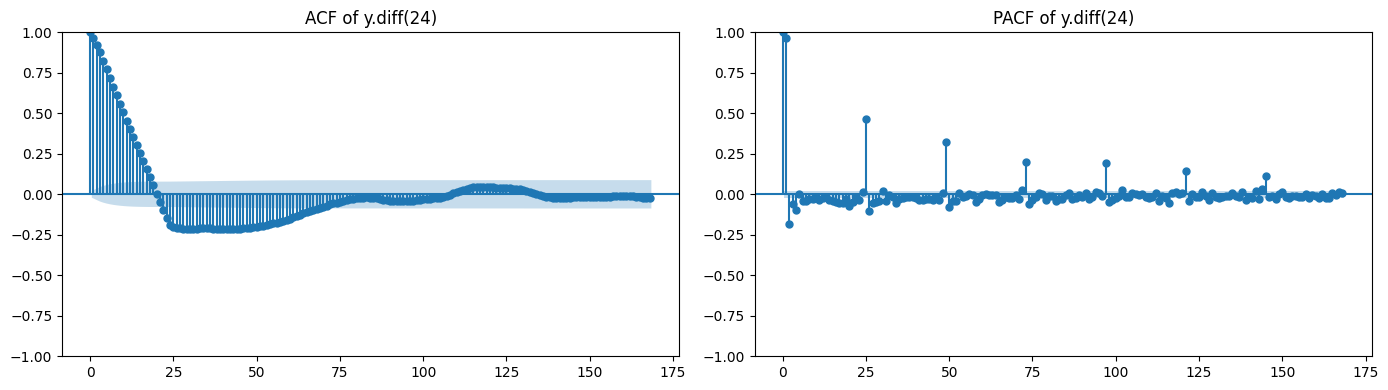

In [ ]:
lags = 7 * m  # e.g., 7 days of lags if hourly

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sm.graphics.tsa.plot_acf(s_seasdiff, lags=lags, ax=axes[0])
axes[0].set_title("ACF of y.diff(24)")

sm.graphics.tsa.plot_pacf(s_seasdiff, lags=lags, ax=axes[1], method="ywm")
axes[1].set_title("PACF of y.diff(24)")

plt.tight_layout()
plt.show()


In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Inputs (edit these)
m = 24
p, d, q = 1, 0, 1
P, D, Q = 1, 1, 1


s_train = s_train.dropna().sort_index()

model = SARIMAX(
    s_train,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m),
    trend="c",                     # try None if you don’t want a constant
    enforce_stationarity=False,
    enforce_invertibility=False
)

best_res = model.fit(disp=False)
print(best_res.summary())

print("\nChosen model:")
print("order =", best_res.model.order)
print("seasonal_order =", best_res.model.seasonal_order)
print("AIC =", best_res.aic, "BIC =", best_res.bic)


                                     SARIMAX Results                                      
Dep. Variable:             Air Temperature_filled   No. Observations:                 8760
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -10903.428
Date:                            Sat, 31 Jan 2026   AIC                          21818.857
Time:                                    20:55:20   BIC                          21861.290
Sample:                                01-01-2016   HQIC                         21833.319
                                     - 12-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.273      0.785      -0.001       0.001
ar.L1          0.9899      0.002   

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = best_res.resid.dropna()
print(acorr_ljungbox(resid, lags=[24, 48, 72, 96, 168], return_df=True))


        lb_stat     lb_pvalue
24   130.141234  1.462611e-16
48   196.890080  6.175827e-20
72   224.441501  1.449982e-17
96   270.634527  1.500292e-18
168  402.596659  2.680644e-21


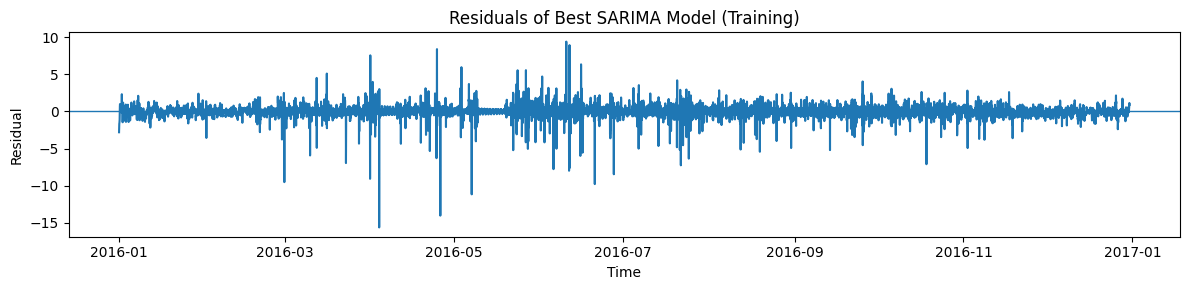

In [ ]:

# best_res = fitted SARIMAXResults from your grid search (best model)
resid = best_res.resid.dropna()

plt.figure(figsize=(12, 3))
plt.plot(resid.index, resid.values)
plt.axhline(0, linewidth=1)
plt.title("Residuals of Best SARIMA Model (Training)")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()


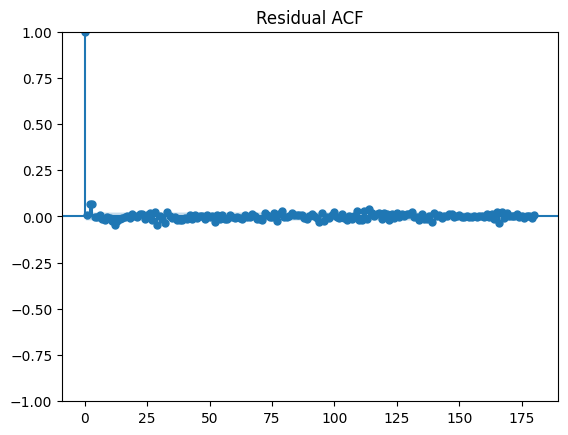

24 -0.016242375678992595
48 -0.014647412230549174
72 0.017488190403979084
96 -0.027326343881414042
168 -0.0056261834871928675


In [ ]:
sm.graphics.tsa.plot_acf(resid, lags=180)
plt.title("Residual ACF")
plt.show()


for L in [24, 48, 72, 96, 168]:
    print(L, pd.Series(resid).autocorr(lag=L))


In [ ]:

res2 = SARIMAX(
    s_train,
    order=(2,1,1),
    seasonal_order=(0,1,2,24),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(res2.aic, res2.bic)
print(res2.summary())


21778.447084615193 21827.932553365918
                                        SARIMAX Results                                        
Dep. Variable:                  Air Temperature_filled   No. Observations:                 8760
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 24)   Log Likelihood              -10882.224
Date:                                 Sat, 31 Jan 2026   AIC                          21778.447
Time:                                         22:33:08   BIC                          21827.933
Sample:                                     01-01-2016   HQIC                         21795.316
                                          - 12-30-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.909e-05   7.28e-05    

        lb_stat     lb_pvalue
24    86.434456  5.564039e-09
48   158.331577  1.043902e-13
72   191.943531  7.480275e-13
96   237.079707  6.212543e-14
168  363.621659  1.795398e-16


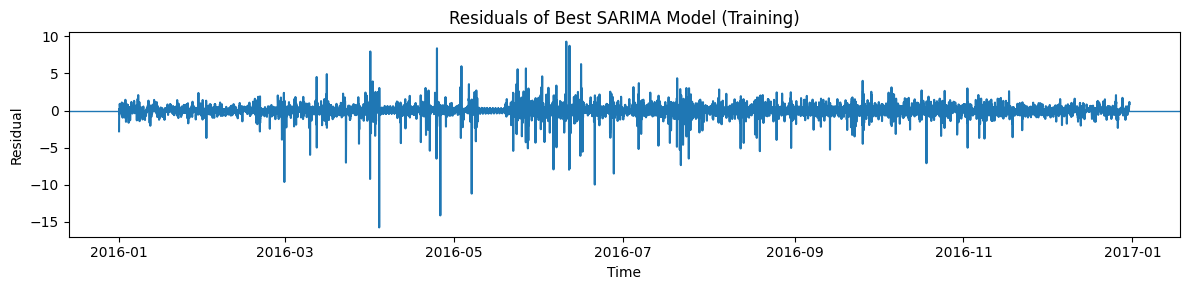

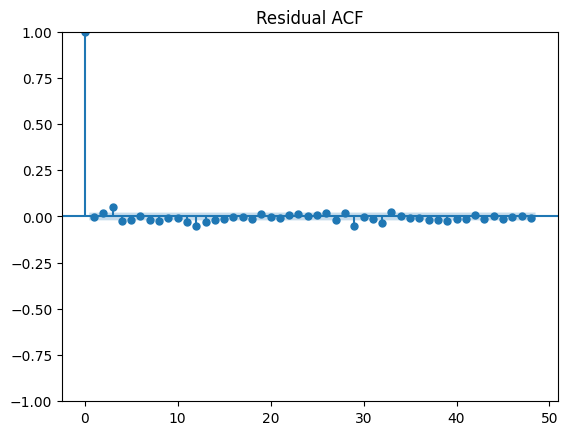

24 0.0008380203094029896
48 -0.010737334963728156
72 0.021763327156015047
96 -0.022145979248174245
168 -0.0017022235531386392


In [ ]:
resid2 = res2.resid.dropna()
print(acorr_ljungbox(resid2, lags=[24, 48, 72, 96, 168], return_df=True))



plt.figure(figsize=(12, 3))
plt.plot(resid2.index, resid2.values)
plt.axhline(0, linewidth=1)
plt.title("Residuals of Best SARIMA Model (Training)")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

sm.graphics.tsa.plot_acf(resid2, lags=48)
plt.title("Residual ACF")
plt.show()


for L in [24, 48, 72, 96, 168]:
    print(L, pd.Series(resid2).autocorr(lag=L))



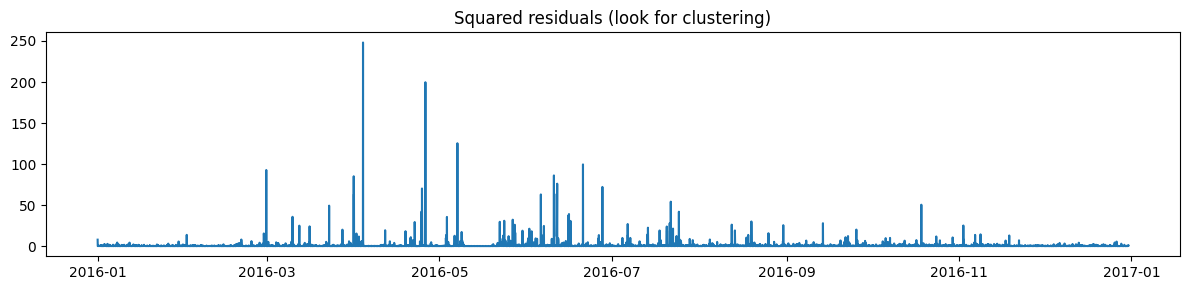

In [ ]:
# check vol clustering

plt.figure(figsize=(12,3))
plt.plot(resid2.index, resid2**2)
plt.title("Squared residuals (look for clustering)")
plt.tight_layout()
plt.show()


In [ ]:
# arch lm test
from statsmodels.stats.diagnostic import het_arch

lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(resid2)
print({"LM stat": lm_stat, "LM pvalue": lm_pvalue, "F stat": f_stat, "F pvalue": f_pvalue})

for L in [5, 10, 24, 48]:
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(resid2, nlags=L)
    print(f"nlags={L:>2} | LM p={lm_pvalue:.3e} | F p={f_pvalue:.3e}")


{'LM stat': np.float64(96.94745931105712), 'LM pvalue': np.float64(2.2207855640352014e-16), 'F stat': 9.791040132201433, 'F pvalue': 1.7949788645706262e-16}
nlags= 5 | LM p=2.376e-18 | F p=1.919e-18
nlags=10 | LM p=2.221e-16 | F p=1.795e-16
nlags=24 | LM p=1.692e-12 | F p=1.391e-12
nlags=48 | LM p=1.132e-13 | F p=7.987e-14


In [ ]:
# !pip install arch
from arch import arch_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 940.5/940.5 kB 11.5 MB/s eta 0:00:00


In [ ]:
eps = resid2.dropna()

# (Optional) scale residuals for numerical stability (common practice)
scale = eps.std()
eps_s = eps / scale

am = arch_model(
    eps_s,
    mean="Zero",       # because SARIMA already models the mean
    vol="GARCH",
    p=1, q=1,
    dist="t"      # try "t" if heavy tails / "normal"
)

garch_res = am.fit(disp="off")
print(garch_res.summary())


                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8755.44
Distribution:      Standardized Student's t   AIC:                           17518.9
Method:                  Maximum Likelihood   BIC:                           17547.2
                                              No. Observations:                 8760
Date:                      Sat, Jan 31 2026   Df Residuals:                     8760
Time:                              22:44:10   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0

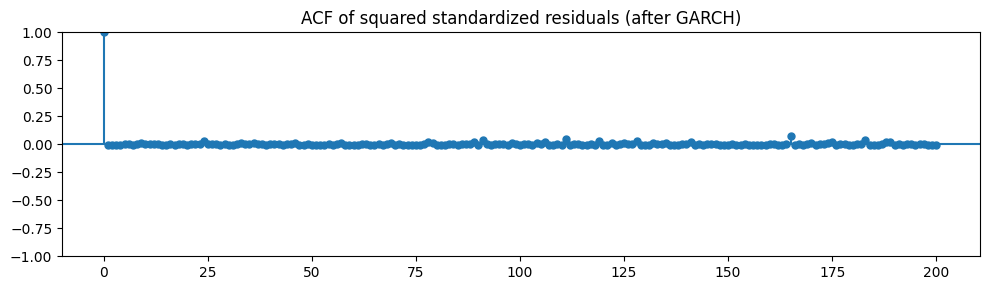

{'LM pvalue (std resid, nlags=24)': np.float64(0.9922791224849299), 'F pvalue': 0.9923359772951323}


In [ ]:
std_resid = garch_res.std_resid  # standardized residuals (should look iid-ish)

# ACF of squared standardized residuals (should be smaller than before)

fig, ax = plt.subplots(1, 1, figsize=(10,3))
sm.graphics.tsa.plot_acf((std_resid**2), lags=200, ax=ax)
ax.set_title("ACF of squared standardized residuals (after GARCH)")
plt.tight_layout()
plt.show()


lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid.dropna(), nlags=24)
print({"LM pvalue (std resid, nlags=24)": lm_pvalue, "F pvalue": f_pvalue})


In [ ]:
for p,q in [(1,1),(1,2),(2,1),(2,2)]:
    am = arch_model(eps_s, mean="Zero", vol="GARCH", p=p, q=q, dist="t")
    r = am.fit(disp="off")
    print((p,q), "AIC", r.aic, "BIC", r.bic)


(1, 1) AIC 17518.884616895273 BIC 17547.196421630993
(1, 2) AIC 17520.884616953885 BIC 17556.274372873537
(2, 1) AIC 17517.009572930932 BIC 17552.399328850584
(2, 2) AIC 17519.00957327293 BIC 17561.477280376515


In [ ]:
# forecast
H = len(s_test)

fc = res2.get_forecast(steps=H)
s_pred = fc.predicted_mean
ci = fc.conf_int()

# Align forecast index to the test index (important!)
s_pred.index = s_test.index
ci.index = s_test.index

print("Forecast horizon H =", H)
print("Train end:", s_train.index.max(), "| Test range:", s_test.index.min(), "->", s_test.index.max())

err = s_test - s_pred
mae = np.mean(np.abs(err))
rmse = np.sqrt(np.mean(err**2))

print({"MAE": float(mae), "RMSE": float(rmse)})

from sklearn.metrics import r2_score
print("Test R^2:", r2_score(s_test, s_pred))

Forecast horizon H = 24
Train end: 2016-12-30 23:00:00 | Test range: 2016-12-31 00:00:00 -> 2016-12-31 23:00:00
{'MAE': 2.5044834037169874, 'RMSE': 2.9117029918487556}
Test R^2: -0.883138622368131


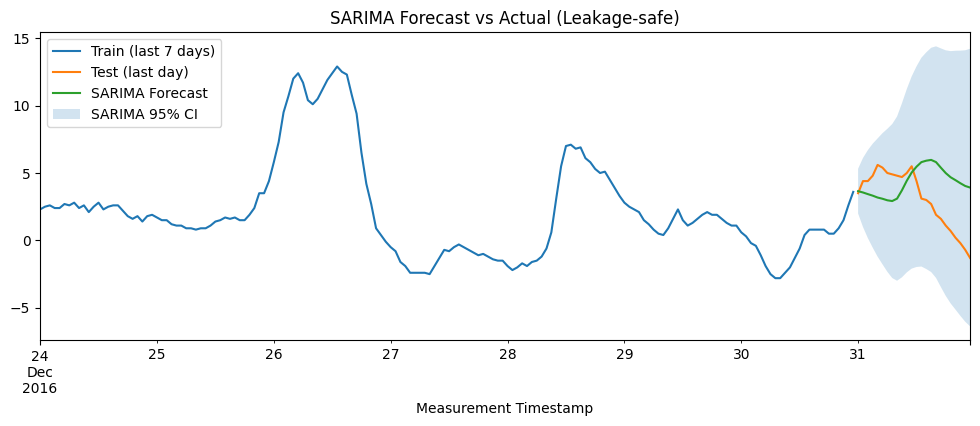

In [ ]:
ax = s_train.iloc[-7*m:].plot(figsize=(12,4), label="Train (last 7 days)")
s_test.plot(ax=ax, label="Test (last day)")
s_pred.plot(ax=ax, label="SARIMA Forecast")

ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="SARIMA 95% CI")
plt.legend()
plt.title("SARIMA Forecast vs Actual (Leakage-safe)")
plt.show()


In [ ]:
# Forecast conditional variance for next H steps
garch_fc = garch_res.forecast(horizon=H, reindex=False)
var_s = garch_fc.variance.values[-1, :]     # scaled variance for steps 1..H
sigma = np.sqrt(var_s) * scale              # back to original scale

# Use t-quantile for 95% PI (since dist="t")
from scipy.stats import t
nu = garch_res.params["nu"]
q975 = t.ppf(0.975, df=nu)

lower_g = s_pred.values - q975 * sigma
upper_g = s_pred.values + q975 * sigma

lower_g = pd.Series(lower_g, index=s_test.index)
upper_g = pd.Series(upper_g, index=s_test.index)

In [ ]:
print(len(s_pred), len(s_test))
print(s_pred.index[0], s_test.index[0])
print(s_pred.index[-1], s_test.index[-1])


24 24
2016-12-31 00:00:00 2016-12-31 00:00:00
2016-12-31 23:00:00 2016-12-31 23:00:00


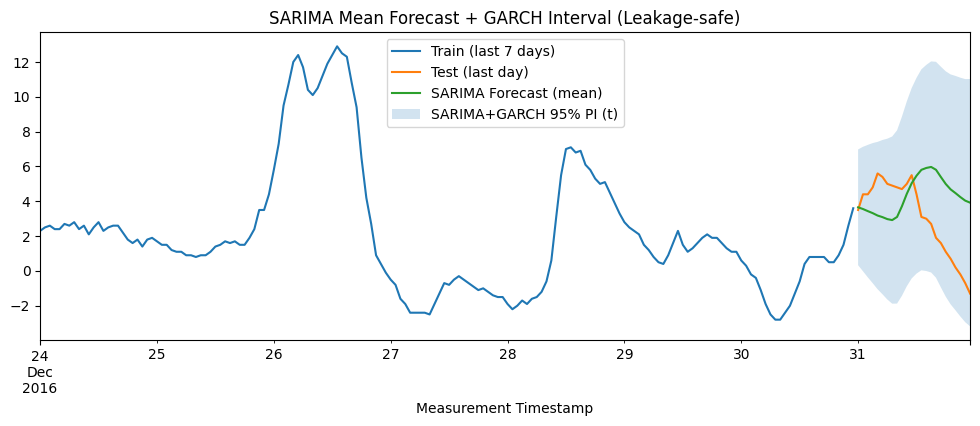

In [ ]:
ax = s_train.iloc[-7*m:].plot(figsize=(12,4), label="Train (last 7 days)")
s_test.plot(ax=ax, label="Test (last day)")
s_pred.plot(ax=ax, label="SARIMA Forecast (mean)")

ax.fill_between(s_test.index, lower_g, upper_g, alpha=0.2, label="SARIMA+GARCH 95% PI (t)")
plt.legend()
plt.title("SARIMA Mean Forecast + GARCH Interval (Leakage-safe)")
plt.show()


In [ ]:
# grid search

import numpy as np
import pandas as pd
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

warnings.filterwarnings("ignore")

def sarima_gridsearch_aic_lb(
    y_train,
    m=24,
    p_vals=(0,1,2),
    d_vals=(0,),               # keep small; add 1 if you want
    q_vals=(0,1,2),
    P_vals=(0,1),
    D_vals=(1,),               # you likely want (1,) for your case
    Q_vals=(0,1,2),
    trend="c",
    lb_lags=None,              # default uses [m,2m,3m,7m] if possible
    enforce_stationarity=False,
    enforce_invertibility=False,
    save_best_models=True      # keep fitted objects for the best models
):
    """
    Returns:
      result_table: DataFrame with model orders, AIC/BIC, and Ljung–Box p-values
      best_res_aic: fitted results object with lowest AIC (if save_best_models)
      best_res_white: fitted results object with highest min Ljung–Box p (tie-break: AIC)
    """
    y_train = y_train.dropna().sort_index()

    if lb_lags is None:
        lb_lags = [m, 2*m, 3*m, 7*m]  # daily + weekly-ish
    lb_lags = [L for L in lb_lags if L < len(y_train)]

    rows = []

    best_res_aic = None
    best_aic = np.inf

    best_res_white = None
    best_min_p = -np.inf
    best_min_p_aic = np.inf

    for d in d_vals:
        for D in D_vals:
            for p in p_vals:
                for q in q_vals:
                    for P in P_vals:
                        for Q in Q_vals:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)

                            try:
                                res = SARIMAX(
                                    y_train,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    trend=trend,
                                    enforce_stationarity=enforce_stationarity,
                                    enforce_invertibility=enforce_invertibility
                                ).fit(disp=False)

                                resid = res.resid.dropna()

                                lb = acorr_ljungbox(resid, lags=lb_lags, return_df=True)
                                # whiteness summary: min p-value across tested lags
                                min_p = float(lb["lb_pvalue"].min())
                                # also store p-values per lag
                                lb_pvals = {f"LB_p{lag}": float(lb.loc[lag, "lb_pvalue"]) for lag in lb.index}

                                row = {
                                    "order": order,
                                    "seasonal_order": seasonal_order,
                                    "AIC": float(res.aic),
                                    "BIC": float(res.bic),
                                    "HQIC": float(res.hqic),
                                    "min_LB_p": min_p
                                }
                                row.update(lb_pvals)
                                rows.append(row)

                                # best by AIC
                                if res.aic < best_aic:
                                    best_aic = res.aic
                                    best_res_aic = res if save_best_models else None

                                # best by whiteness (highest min p), tie-break by AIC
                                if (min_p > best_min_p) or (min_p == best_min_p and res.aic < best_min_p_aic):
                                    best_min_p = min_p
                                    best_min_p_aic = res.aic
                                    best_res_white = res if save_best_models else None

                                print(f"OK {order} x {seasonal_order} | AIC={res.aic:.2f} | min_LB_p={min_p:.2e}")

                            except Exception as e:
                                print(f"FAIL {order} x {seasonal_order} | {e}")

    result_table = pd.DataFrame(rows)

    # Two useful sorted views:
    # 1) primary AIC, secondary whiteness
    result_aic = result_table.sort_values(["AIC", "min_LB_p"], ascending=[True, False]).reset_index(drop=True)
    # 2) primary whiteness, secondary AIC
    result_white = result_table.sort_values(["min_LB_p", "AIC"], ascending=[False, True]).reset_index(drop=True)

    return result_aic, result_white, best_res_aic, best_res_white, lb_lags


In [ ]:
result_aic, result_white, best_res_aic, best_res_white, lb_lags = sarima_gridsearch_aic_lb(
    y_train,
    m=24,
    p_vals=(1,2),
    d_vals=(0,),
    q_vals=(0,1),
    P_vals=(0,1),
    D_vals=(1,),
    Q_vals=(1,2),
    trend="c",
    lb_lags=[24, 48, 72, 96, 168]   # you can adjust
)

print("\nLjung–Box lags used:", lb_lags)

print("\nTop 10 by AIC (tie-break: whiteness):")
print(result_aic.head(10)[["order","seasonal_order","AIC","BIC","min_LB_p"]])

print("\nTop 10 by whiteness (tie-break: AIC):")
print(result_white.head(10)[["order","seasonal_order","AIC","BIC","min_LB_p"]])

print("\nBest-by-AIC model:")
print("order =", best_res_aic.model.order)
print("seasonal_order =", best_res_aic.model.seasonal_order)
print("AIC =", best_res_aic.aic)

print("\nBest-by-whiteness model:")
print("order =", best_res_white.model.order)
print("seasonal_order =", best_res_white.model.seasonal_order)
print("min_LB_p =", result_white.iloc[0]["min_LB_p"], "AIC =", best_res_white.aic)


KeyboardInterrupt: 

In [ ]:
# NOT USED
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def residual_whiteness_diagnostics(res, m=24, max_lags=None):
    """
    Diagnostics for whether residuals look like white noise.
    res: fitted SARIMAXResults (e.g., best_res)
    m: seasonal period (24 for hourly daily)
    max_lags: max lags for ACF/PACF plots; default shows about a week for hourly
    """
    resid = res.resid.dropna()

    if max_lags is None:
        max_lags = 7 * m  # show a week worth of lags for hourly

    # 1) Residual time series
    plt.figure(figsize=(12, 3))
    plt.plot(resid.index, resid.values)
    plt.title("Residuals (time series)")
    plt.axhline(0, linewidth=1)
    plt.tight_layout()
    plt.show()

    # 2) Residual ACF & PACF side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sm.graphics.tsa.plot_acf(resid, lags=max_lags, ax=axes[0])
    axes[0].set_title("Residual ACF")

    # PACF can be unstable with huge lags; cap it conservatively
    pacf_lags = min(max_lags, max(20, int(len(resid) / 10)))
    sm.graphics.tsa.plot_pacf(resid, lags=pacf_lags, ax=axes[1], method="ywm")
    axes[1].set_title(f"Residual PACF (lags={pacf_lags})")

    plt.tight_layout()
    plt.show()

    # 3) Ljung–Box test (no autocorrelation up to lag h)
    # Include seasonal lags explicitly
    candidate_lags = sorted(set([10, 20, m, 2*m, 3*m]))
    candidate_lags = [lag for lag in candidate_lags if lag < len(resid)]

    lb = acorr_ljungbox(resid, lags=candidate_lags, return_df=True)
    print("Ljung–Box test (H0: no autocorrelation up to lag h):")
    print(lb)

    # 4) Optional: ARCH test (volatility clustering)
    arch_stat, arch_pval, f_stat, f_pval = het_arch(resid)
    print("\nARCH LM test (H0: no ARCH / constant variance):")
    print({"LM stat": arch_stat, "LM pvalue": arch_pval, "F stat": f_stat, "F pvalue": f_pval})

    return lb

# Run it
lb_table = residual_whiteness_diagnostics(best_res, m=24)


In [ ]:
# Add fourier terms
def fourier_features_time(index, period_hours, K, prefix, origin=None):
    if origin is None:
        origin = index.min()
    # hours since origin (works for hourly series; if not hourly, use total_seconds/3600)
    t = (index - origin) / pd.Timedelta(hours=1)
    t = t.astype(float)

    X = {}
    for k in range(1, K + 1):
        X[f"{prefix}_sin{k}"] = np.sin(2*np.pi*k*t/period_hours)
        X[f"{prefix}_cos{k}"] = np.cos(2*np.pi*k*t/period_hours)
    return pd.DataFrame(X, index=index)

origin = s.index.min()  # use the full series start as anchor

X_train = fourier_features_time(s_train.index, period_hours=168, K=3, prefix="w", origin=origin)
X_test  = fourier_features_time(s_test.index,  period_hours=168, K=3, prefix="w", origin=origin)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_res = SARIMAX(
    s_train,
    exog=X_train,
    order=(2,1,1),
    seasonal_order=(0,1,2,24),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

print(sarimax_res.summary())


                                        SARIMAX Results                                        
Dep. Variable:                  Air Temperature_filled   No. Observations:                 8760
Model:             SARIMAX(2, 1, 1)x(0, 1, [1, 2], 24)   Log Likelihood              -10881.108
Date:                                 Sun, 01 Feb 2026   AIC                          21788.217
Time:                                         12:45:58   BIC                          21880.118
Sample:                                     01-01-2016   HQIC                         21819.544
                                          - 12-30-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.114e-06   7.44e-05     -0.096      0.924      -0.000       0

In [ ]:
H = len(s_test)

fc = sarimax_res.get_forecast(steps=H, exog=X_test)
y_pred_fx = fc.predicted_mean
ci_fx = fc.conf_int()

# align indexes
y_pred_fx.index = s_test.index
ci_fx.index = s_test.index


r2 = r2_score(s_test, y_pred_fx)
mae = np.mean(np.abs(s_test - y_pred_fx))
rmse = np.sqrt(np.mean((s_test - y_pred_fx)**2))
print({"R2": float(r2), "MAE": float(mae), "RMSE": float(rmse)})


{'R2': -0.9363651323381827, 'MAE': 2.5099959992093566, 'RMSE': 2.9525655914978945}


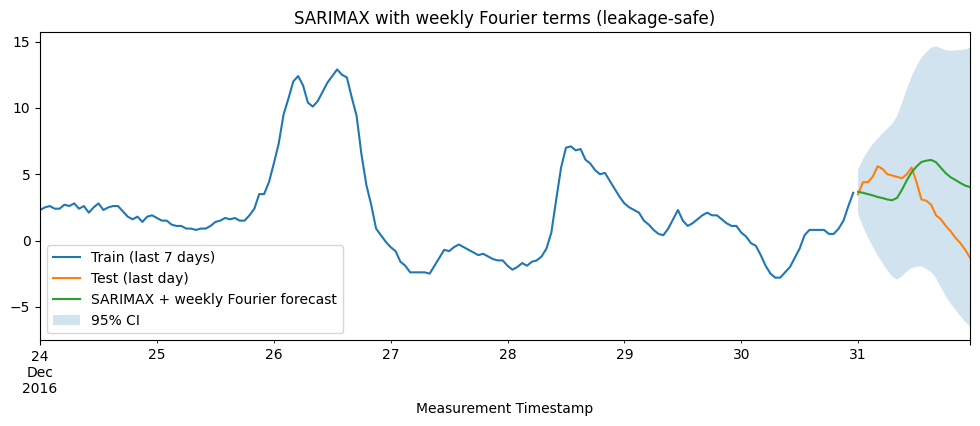

In [ ]:

ax = s_train.iloc[-7*24:].plot(figsize=(12,4), label="Train (last 7 days)")
s_test.plot(ax=ax, label="Test (last day)")
y_pred_fx.plot(ax=ax, label="SARIMAX + weekly Fourier forecast")
ax.fill_between(ci_fx.index, ci_fx.iloc[:,0], ci_fx.iloc[:,1], alpha=0.2, label="95% CI")
plt.legend()
plt.title("SARIMAX with weekly Fourier terms (leakage-safe)")
plt.show()


In [ ]:

def rolling_one_day_rmse(y, order=(1,0,1), seasonal_order=(0,1,1,24), last_days=14):
    y = y.dropna().sort_index()
    steps = 24
    rmses = []
    end_points = []

    for d in range(last_days, 0, -1):
        train_end = y.index.max() - pd.Timedelta(days=d)
        y_train = y.loc[:train_end]
        y_test  = y.loc[train_end + pd.Timedelta(hours=1): train_end + pd.Timedelta(hours=steps)]

        if len(y_test) < steps:
            continue

        res = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                      trend="c", enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        pred = res.get_forecast(steps=steps).predicted_mean
        pred.index = y_test.index

        rmse = np.sqrt(np.mean((y_test - pred)**2))
        rmses.append(rmse)
        end_points.append(train_end)

    return pd.Series(rmses, index=end_points)

rmses = rolling_one_day_rmse(s, last_days=7)
print("RMSE mean:", rmses.mean(), "median:", rmses.median(), "max:", rmses.max())


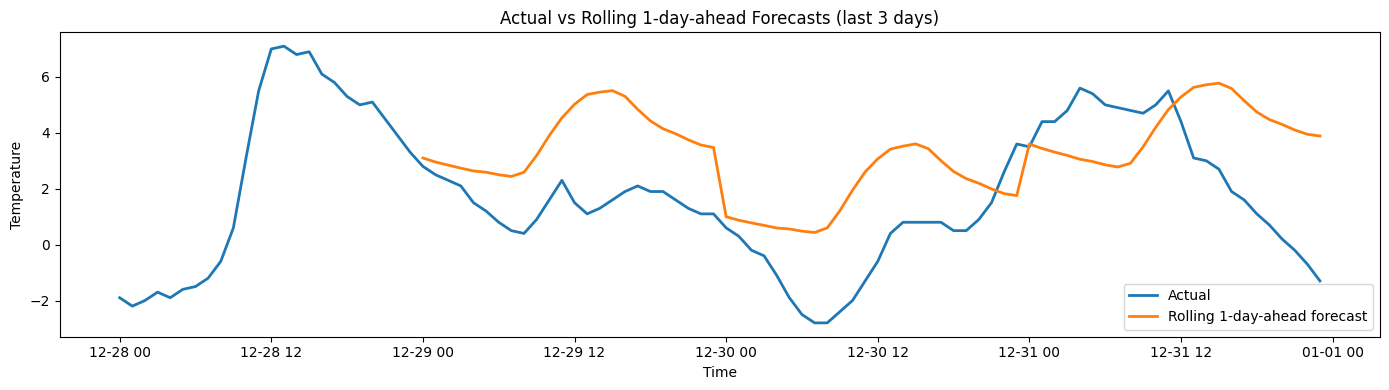

In [ ]:


def rolling_forecast_14days_plot(
    y,
    order=(1,0,1),
    seasonal_order=(0,1,1,24),
    last_days=14,
    steps_per_day=24
):
    y = y.dropna().sort_index()

    # We'll store forecasts in a single Series aligned to the original timeline
    y_pred_all = pd.Series(index=y.index, dtype=float)

    # For each of the last `last_days` days, train up to end of previous day and forecast next day
    for d in range(last_days, 0, -1):
        # train ends at the end of the day (d days before the end)
        train_end = (y.index.max().normalize() - pd.Timedelta(days=d)) + pd.Timedelta(hours=23)

        y_train = y.loc[:train_end]
        test_start = train_end + pd.Timedelta(hours=1)
        test_end = train_end + pd.Timedelta(hours=steps_per_day)

        y_test_day = y.loc[test_start:test_end]
        if len(y_test_day) < steps_per_day:
            continue

        res = SARIMAX(
            y_train,
            order=order,
            seasonal_order=seasonal_order,
            trend="c",
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        fc = res.get_forecast(steps=steps_per_day)
        pred = fc.predicted_mean
        pred.index = y_test_day.index  # align timestamps

        # fill into the big container
        y_pred_all.loc[pred.index] = pred.values

    # Slice out only the region we care about (last_days days)
    plot_start = y.index.max().normalize() - pd.Timedelta(days=last_days)  # start at midnight
    y_actual_14 = y.loc[plot_start:]
    y_pred_14 = y_pred_all.loc[plot_start:]

    # Plot
    plt.figure(figsize=(14,4))
    plt.plot(y_actual_14.index, y_actual_14.values, label="Actual", linewidth=2)
    plt.plot(y_pred_14.index, y_pred_14.values, label="Rolling 1-day-ahead forecast", linewidth=2)
    plt.title(f"Actual vs Rolling 1-day-ahead Forecasts (last {last_days} days)")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred_14, y_actual_14

# Usage:
y_pred_14, y_actual_14 = rolling_forecast_14days_plot(
    s,
    order=(1,0,1),
    seasonal_order=(0,1,1,24),
    last_days=3,
    steps_per_day=24
)
